# Машинное обучение, ФКН ВШЭ
## Практическое задание 3.

__Дата выдачи: 14.11.2016__
__Дедлайн: 28.11.2016 05:59__

Задание состоит из трех независимых разделов, посвященных bias-variance decomposition, решающим деревьям и композициям алгоритмов. Эти разделы можно выполнять в любом порядке. В каждом разделе вам предложена одна или две задачи, которые, в свою очередь, делятся на пункты. Баллы даются за выполнение пунктов, причем в рамках одной задачи пункты, как правило, зависимы (нельзя решить следующий, не решив предыдущего). Пункты могут быть двух видов: написать скрипт или ответить на вопросы. Задачи в рамках одного раздела рекомендуется решать в том порядке, в котором они даны в задании. В разных задачах используются разные наборы данных, все наборы взяты из репозитория UCI. 

Задание направлено на более глубокое ознакомление с тем, как работают решающие деревья, случайные леса и как устроено разложение на смещение и разброс. Кроме того, задание предполагает проведение экспериментов и анализ их результатов (мини-исследования). 

Для сдачи задания переименуйте получившийся файл \*.ipynb в соответствии со следующим форматом: HW3_Username.ipynb, где Username — Ваша фамилия и инициалы на латинице (например, HW3_IvanovII.ipynb). Далее отправьте этот файл на hse.cs.ml+<номер группы>@gmail.com (например, hse.cs.ml+141@gmail.com для студентов группы БПМИ-141).

### I. Разложение ошибки на смещение и разброс
#### Теоретическое вступление
На занятиях мы разбирали примеры аналитического вычисления смещения и разброса нескольких алгоритмов обучения. Для большинства моделей данных и алгоритмов обучения аналитически рассчитать математические ожидания в формулах не удастся. Однако мат. ожидания можно оценивать приближенно. Чтобы оценить математическое ожидание $\mathbb{E}_{\bar x} f(\bar x)$ функции от многомерной случайной величины $\bar x = (x_1, \dots, x_d)$, $\bar x \sim p(\bar x)$, можно сгенерировать выборку из распределения $p(\bar x)$ и усреднить значение функции на элементах этой выборки:
$$\mathbb{E}_{\bar x} f(x) = \int f(\bar x) p(\bar x) d \bar x \approx \sum_{i=1}^m f(\bar x_i), \, \bar x_i \sim p(\bar x), i = 1, \dots, m.$$

Для оценки многомерных интегралов ($d > 1$) объекты лучше генерировать, следуя специальным схемам, чтобы адекватно оценивать значение интеграла в областях высокой плотности. Мы не будем так усложнять задачу, а просто будем генерировать $\bar x_i$ независимо.

In [1]:

%matplotlib inline
import numpy as np
import pandas as pd
from math import ceil
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import BaggingRegressor, GradientBoostingRegressor, BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, ShuffleSplit
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.base import BaseEstimator


Например, оценим $\mathbb{E}_x x^2,$ $x \sim \mathcal{N}(\mu=5, \sigma=3)$ (из теории вероятностей мы знаем, что
$\mathbb{E}_x x^2 = \sigma^2 + \mu^2 = 34$):

In [17]:
x = np.random.normal(loc=5, scale=3, size=1000)
(x**2).mean()

33.213709159553822

Или посчитаем многомерный интеграл $\mathbb{E}_{\bar x} \bar x^T \bar x = \mathbb{E}_{\bar x} \sum_{i=1}^d x_i^2$, $\bar x \sim \mathcal{N}(\bar \mu=(1, \dots, 1), \Sigma=I)$ при $d = 10$ (аналитический ответ 20):

In [18]:
d = 10
X = np.random.multivariate_normal(np.ones(10), np.eye(10), size=1000)
(X**2).sum(axis=1).mean()

19.920960196382701

Чтобы оценить интеграл по выборке, можно сгенерировать несколько выборок, вычислить на них значение функции и усреднить. Например, для интеграла $\mathbb{E}_X [\mu(X)(x)]$ генерируются выборки $X_1, \dots, X_m$, на каждой из них обучается алгоритм $\mu$ и делается предсказание для объекта $x$.

#### Практическая часть
##### Задача 1. Построение "среднего" алгоритма $\mathbb{E}_X [\mu(X)]$
В этом задании вам нужно построить графики, демонстрирующие, как алгоритм $\mathbb{E}_X [\mu(X)]$ аппроксимирует истинную зависимость в данных и как он меняется в зависимости от гиперпараметров метода обучения.

In [648]:
def f(x):
    return np.sin(x)   # истинная зависимость в данных
sample_size = 100      # длина выборки
samples_num = 20       # количество выборок
linspace = np.linspace(0, 7, 1000)  # точки для построения графиков

__1 (0.3 балла)__
1. Сгенерируйте выборку x из одномерного экспоненциального распределения (np.random.exponential) длины sample_size.
1. Создайте вектор целевых переменных y как сумму f(x) и случайного шума, сгенерированного из равномерного распределения на отрезке [-1, 1] (np.random.uniform).
1. Обучите DecisionTreeRegressor с параметрами по умолчанию на полученной выборке и сделайте предсказания для объектов из linspace.
1. Постройте два графика на одном рисунке: f(x) и зависимость, восстановленную решающим деревом.

    Рекомендация: не забудьте, что все методы обучения в sklearn требуют на вход двумерную матрицу объекты-признаки. Сделать такую из одномерного вектора можно добавлением мнимых осей (np.newaxis).

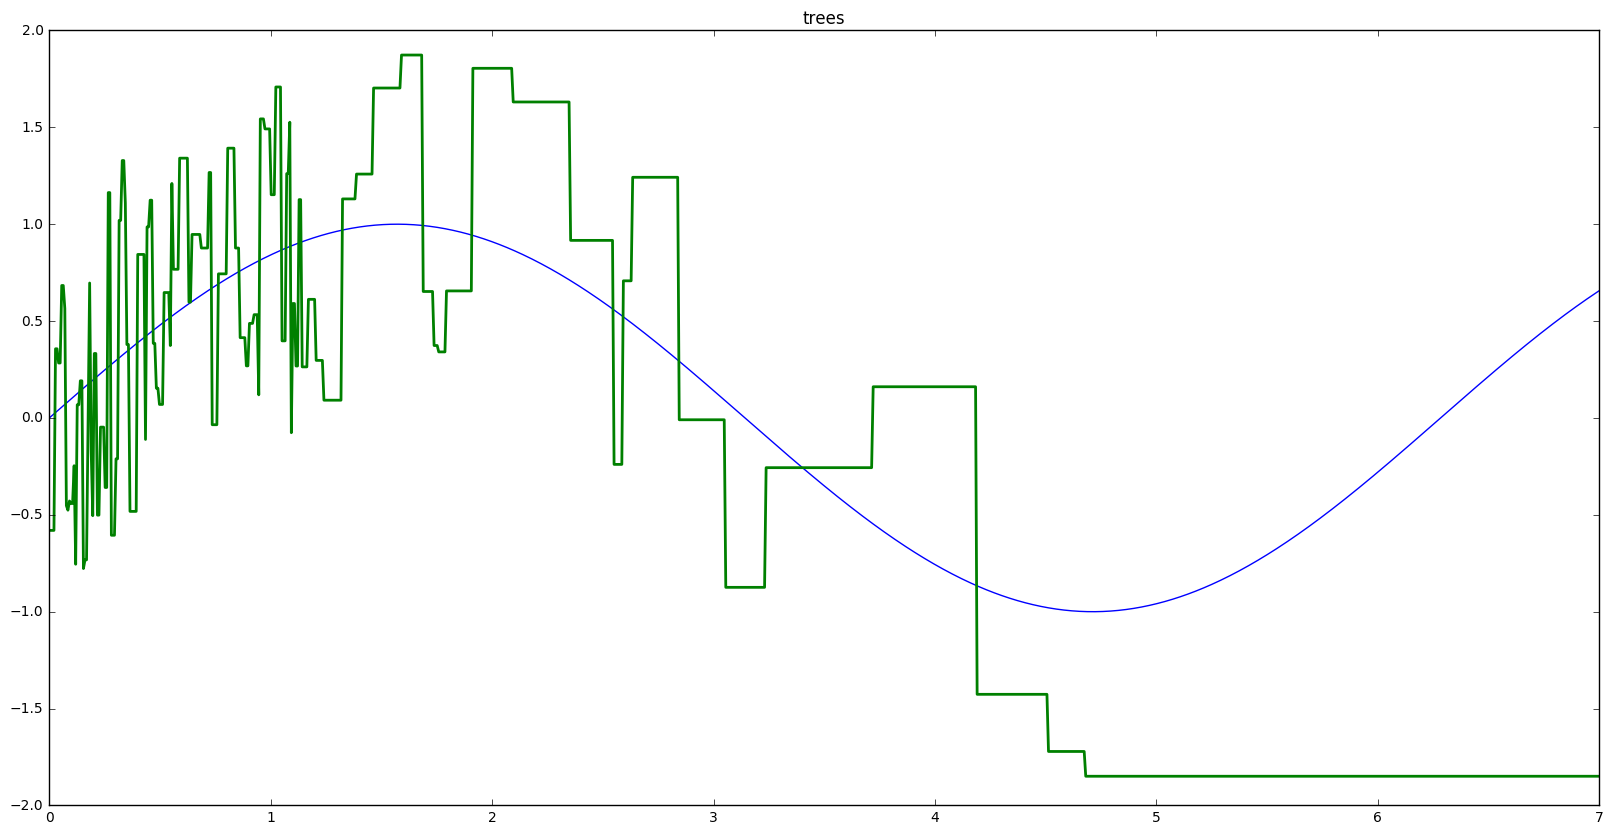

In [649]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
X = np.random.exponential(size=sample_size)
y = f(X) + np.random.uniform(low=-1.0, high=1.0, size=sample_size)
tr = DecisionTreeRegressor()
tr.fit(X[:, np.newaxis], y)
fig, ax = plt.subplots(figsize=(20, 10))
# plt.xlim([0, 1])
plt.plot(linspace, f(linspace))
plt.plot(linspace, tr.predict(linspace.reshape(-1, 1)), c='green', linewidth=2)
plt.title('trees')

__2 (0.3 балла):__

Повторите первые 3 шага, описанные выше, samples_num раз. На одном графике для каждого обученного решающего дерева визуализируйте восстановленную им зависимость (рекомендуется все такие линии рисовать полупрозрачными и серым цветом: plt.plot(...... color="gray", alpha=0.5)).  На этом же графике изобразите истинную зависимость f(x) (красным цветом: color="red") и усредненную по всем деревьям восстановленную зависимость (черным цветом: color="black").    

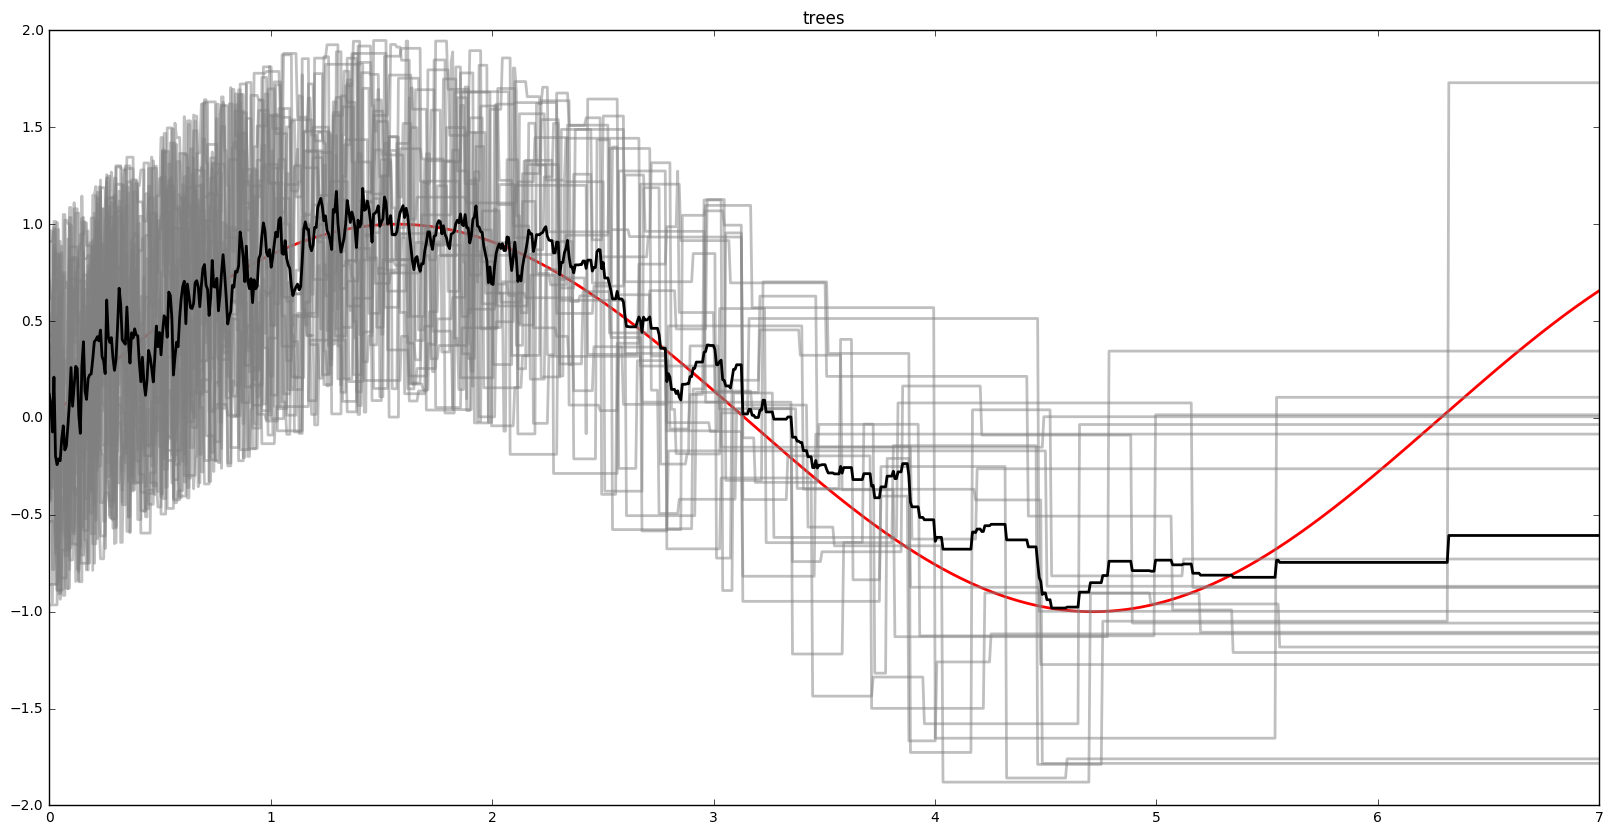

In [650]:
predictions = []
for i in range(samples_num):
    X = np.random.exponential(size=sample_size)
    y = f(X) + np.random.uniform(low=-1.0, high=1.0, size=sample_size)
    tr = DecisionTreeRegressor()
    tr.fit(X[:, np.newaxis], y)
    predictions.append(tr.predict(linspace.reshape(-1, 1)))

fig, ax = plt.subplots(figsize=(20, 10))
# plt.xlim([0, 1])
plt.plot(linspace, f(linspace), c='red', linewidth=2)
for pred in predictions:
    plt.plot(linspace, pred, c='gray', alpha=0.5, linewidth=2)
plt.plot(linspace, np.sum(np.array(predictions), axis=0) / samples_num, c='black', linewidth=2)

plt.title('trees')
    

__3 (0.1 балла):__
Повторите предыдущий пункт, установив максимальную глубину решающего дерева равной 2, а затем равной 4. Таким образом, у вас получится еще два графика.

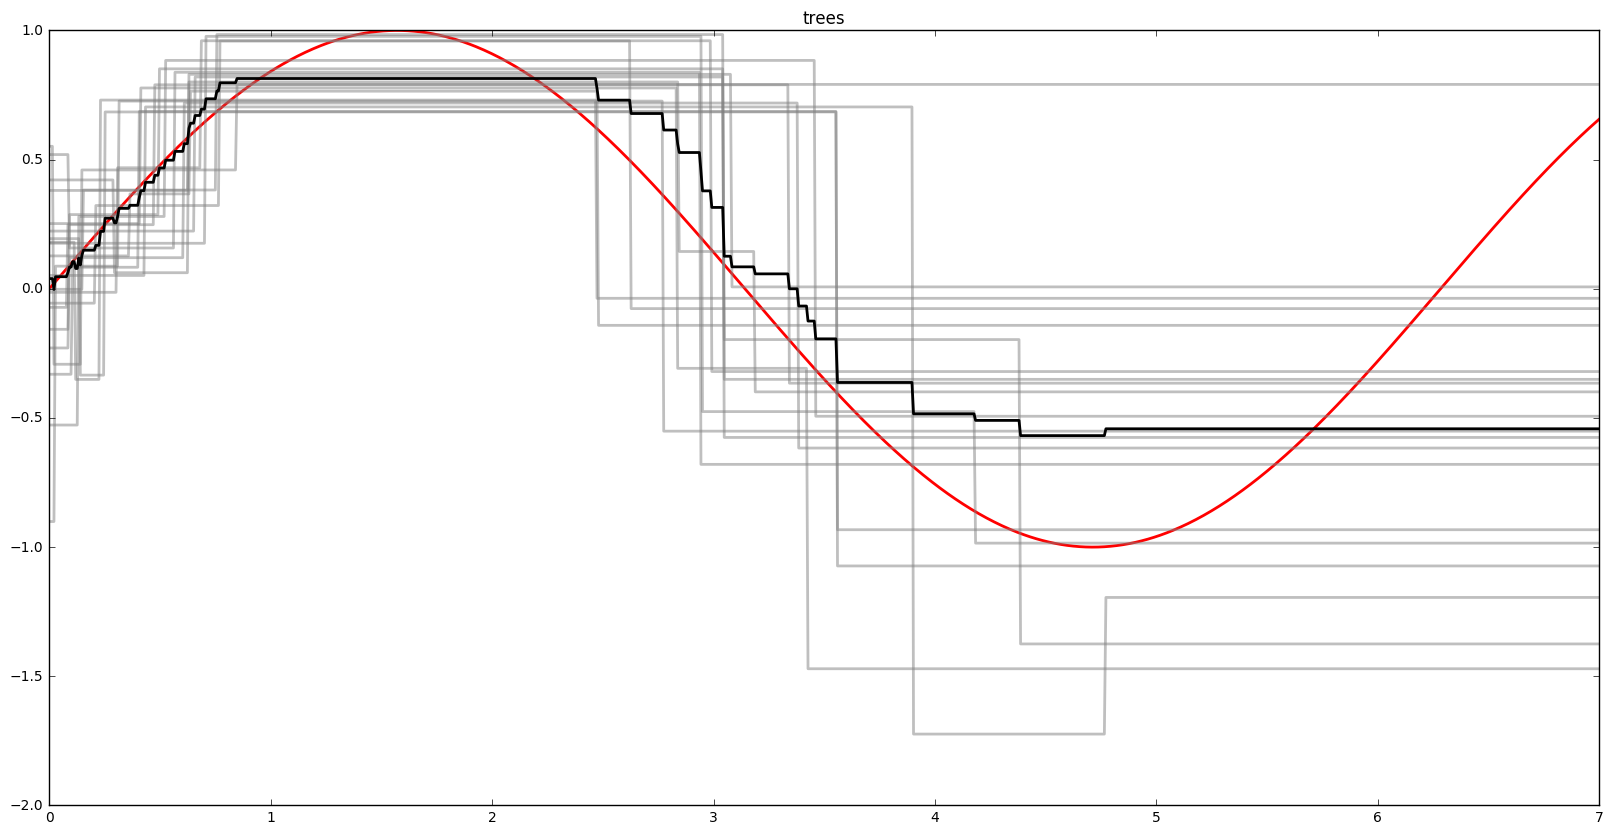

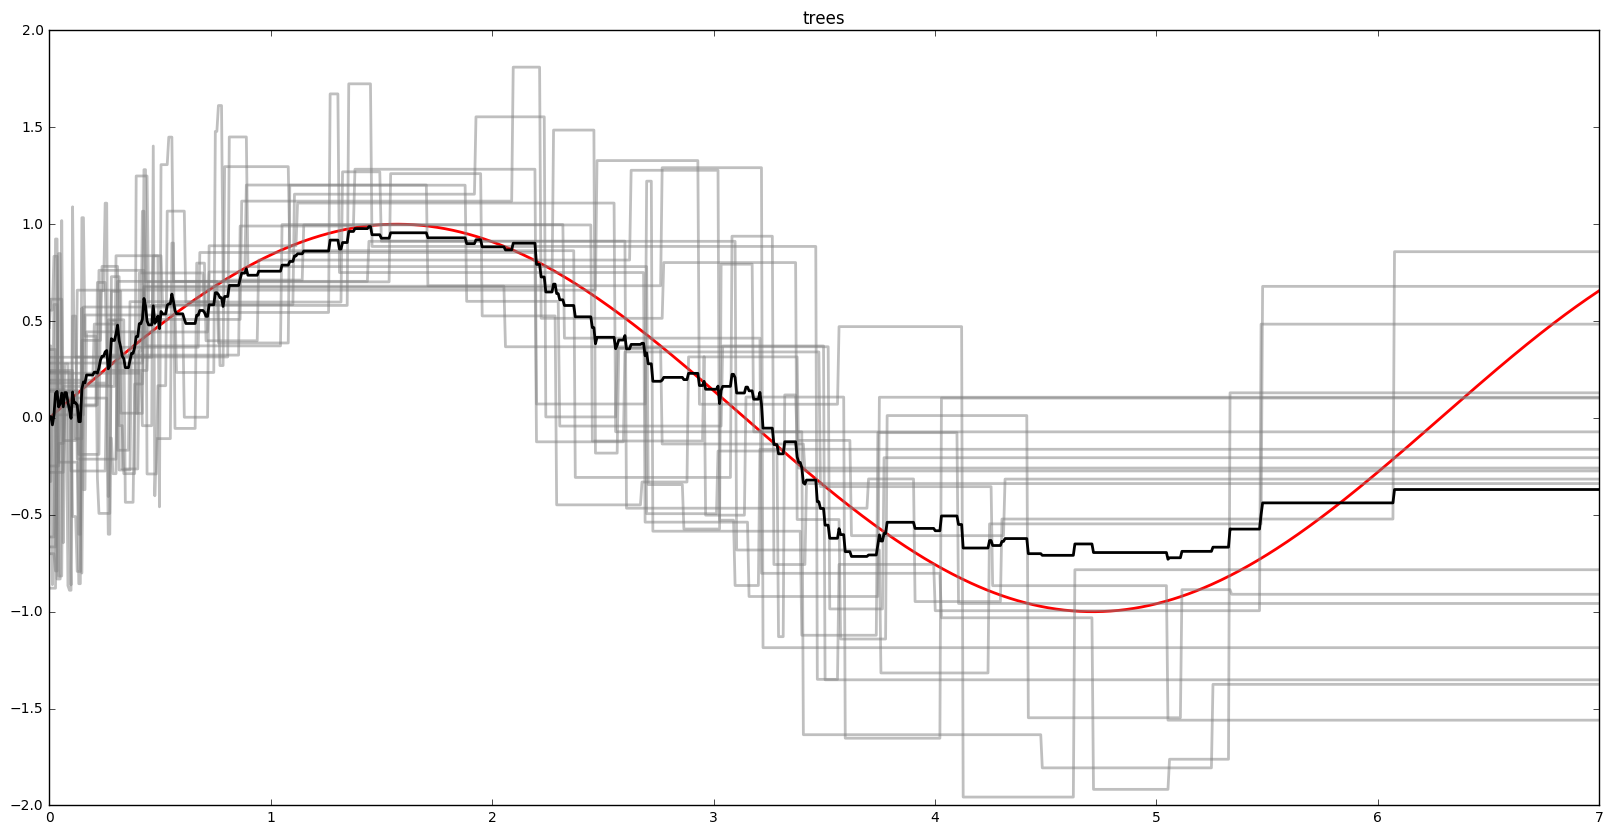

In [651]:
for depth in [2,4]:
    predictions = []
    for i in range(samples_num):
        X = np.random.exponential(size=sample_size)
        y = f(X) + np.random.uniform(low=-1.0, high=1.0, size=sample_size)
        tr = DecisionTreeRegressor(max_depth=depth)
        tr.fit(X[:, np.newaxis], y)
        predictions.append(tr.predict(linspace.reshape(-1, 1)))

    fig, ax = plt.subplots(figsize=(20, 10))
#     plt.xlim([0, 1])
    plt.plot(linspace, f(linspace), c='red', linewidth=2)
    for pred in predictions:
        plt.plot(linspace, pred, c='gray', alpha=0.5, linewidth=2)
    plt.plot(linspace, np.sum(np.array(predictions), axis=0) / samples_num, c='black', linewidth=2)

    plt.title('trees')

__4 (0.3 балла)__ Что можно сказать о смещении решающих деревьев, исходя из проведенного эксперимента? В каких из трех рассмотренных случаев (без ограничения на глубину дерева и с ограничением 2 и 4) можно утверждать, что смещение решающего дерева близко к нулю?

(・・ ) ?

Вообще, на глазок тут сложно определить, какой из рассмотренных случаев имеет более низкое (близкое к нулю) смещение. Я бы сказал, что для случая без органичением глубины, средний ответ алгоритмов всех лучше аппроксимировал истинную зависимость, т.е. черная линия всех ближе находится к красной по абсолютной величине на первой картинке. Но это не точно, так как на первом графике очень колбасит черную линию, так, что она может быть хуже той, что на третьей. И вообще, такие сильные скачки могут говорить о переобучении. С другой стороны, отклонения вворх и вниз примерно одинаковы для случаев без ограничения глубины и с ограниением 4, так что, впринципе, можно утверждать, что они имеют близкое к нулю смещение. Всех хуже на второй, где в качестве базовых моделей были выбраны деревья с ограничением глубины 2 (сложно такой простой моделью хорошо приблизить). На изгибах там совсем грустные результаты.


#### Задача 2. Приближенное оценивание смещения и разброса
Реализуем стохастическую процедуру оценивания смещения и разброса алгоритма.

Будем считать, что каждый объект представлен одним признаком, сгенерированным из некоторого распределения, а значение целевой переменной на этом объекте - это сумма значения истинной функции на объекте плюс шумовая компонента, также сгенерированная из некоторого распределения.

__4 (1 балл) __Реализуйте функцию:

In [137]:
def compute_bias_variance(regressor, dependence_fun, x_generator=np.random.uniform, noise_generator=np.random.uniform,
                          sample_size=100, samples_num=100, objects_num=50):
    X = x_generator(size=sample_size)
    y = dependence_fun(X)
#     print(np.mean(dependence_fun(X) ** 2)) затестил для X^2 b cos(x) работает огонь

#     noise = noise_generator(size=objects_num)
    noise = noise_generator(size=sample_size)
    y_n = y + noise.mean()
    #     сумма правильного ответа на объекте и мат. ожидания шума (который оценивается 
    # генерацией отдельной шумовой выборки длины objects_num и усреднением значений в ней). 
    E_y_with_x = y + np.mean(noise, axis=0)
    
    mean_prediction = np.zeros(sample_size)
    for i in range(samples_num):
        X_sample = x_generator(size=sample_size)
        y_sample = dependence_fun(X_sample) + noise_generator(size=sample_size)
        tr = regressor()
        tr.fit(X_sample[:, np.newaxis], y_sample)
        mean_prediction += tr.predict(X[:, np.newaxis]) / samples_num
    #     Смещение:
#     bias = np.mean((y_n - mean_prediction) ** 2, axis=0) #NE GOOD
    bias = np.mean((y + noise - mean_prediction) ** 2, axis=0)
    #     Разброс
    var_prediction = np.zeros(sample_size)
    for i in range(samples_num):
        X_sample = x_generator(size=sample_size)
        y_sample = dependence_fun(X_sample) + noise_generator(size=sample_size)
        tr = regressor()
        tr.fit(X_sample[:, np.newaxis], y_sample)
        var_prediction += (tr.predict(X.reshape(-1, 1)) - mean_prediction) ** 2 / samples_num
    variance = np.mean(var_prediction, axis=0)
    return bias, variance

__5 (0.4 балла) Заполните таблицу.__ 

Пусть истинная зависимость данных задается функцией $5\sin (10 x)$, а значения признаков и шум генерируются из одного и того же распределения. Будем пробовать 4 разных распределения и сравнивать 4 регрессионных алгоритма (см. таблицы ниже). Необходимо в каждую ячейку датафреймов bias и variance записать записать соответственно смещение и разброс, рассчитанные для алгоритма, задаваемого строкой таблицы, и генератора случайных чисел, задаваемого столбцом. Остальные параметры функции compute_bias_variance оставьте по умолчанию.

In [138]:
compute_bias_variance(regressor=LinearRegression, dependence_fun=lambda x: x ** 2, noise_generator=lambda size: np.random.normal(0, 1, size=size), x_generator=lambda size: np.random.normal(0, 1, size=size), sample_size=1000)

# print(compute_bias_variance(regressor=LinearRegression, dependence_fun=lambda x:5 * np.sin(10 * x)))

(3.3062062555843177, 0.013406522816741954)

In [140]:
# import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [141]:
regressors = [LinearRegression, 
              DecisionTreeRegressor, 
              RandomForestRegressor,
              GradientBoostingRegressor]
generators = [lambda size: np.random.normal(0, 0.3, size=size), 
              lambda size: np.random.exponential(0.3, size=size), 
              lambda size: np.random.uniform(-1, 1, size=size),
              np.random.uniform]

In [142]:
bias = pd.DataFrame(columns=["normal(0, 0.3)", "exponential(0.3)", "uniform(-1, 1)", "uniform(0, 1)"],
                      index=["LinearRegression", "DecisionTree", "RandomForest", "GradientBoosting"])
variance = pd.DataFrame(columns=bias.columns, index=bias.index)

In [143]:
for idx_r, regressor in enumerate(regressors):
    for idx_g, generator in enumerate(generators):
        bias.ix[idx_r, idx_g], variance.ix[idx_r, idx_g] = compute_bias_variance(regressor=regressor, dependence_fun=lambda x:5 * np.sin(10 * x),
                                                                                x_generator=generator, noise_generator=generator)
        

In [144]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
bias

,"normal(0, 0.3)",exponential(0.3),"uniform(-1, 1)","uniform(0, 1)"
LinearRegression,12.5827,9.4661,12.3036,9.77146
DecisionTree,0.201151,0.132657,0.363862,0.0964987
RandomForest,0.439605,0.245668,0.379235,0.0755839
GradientBoosting,0.166332,0.143553,0.364372,0.0810273


In [145]:
variance

,"normal(0, 0.3)",exponential(0.3),"uniform(-1, 1)","uniform(0, 1)"
LinearRegression,0.240682,0.359361,0.189478,0.221804
DecisionTree,0.464641,0.225643,0.608375,0.150996
RandomForest,0.209027,0.269155,0.39123,0.103046
GradientBoosting,0.561639,0.339412,0.391863,0.121048


__6 (0.6 балла) Проанализируйте полученные таблицы. Ответьте на вопросы:__
* Отранжируйте алгоритмы в порядке увеличения разброса (если какие-то алгоримты в разных случаях ранжируются по-разному, поставьте их на одну ступень). Согласуется ли полученный результат с теоретическими рассуждениями из лекций (поясните, почему да или нет)?
* Можно ли сказать, что смещение и разброс алгоритма определяются только самим алгоритмом и не зависят от вероятностной модели данных, к которым этот алгоритм применяется (поясните, почему да или нет)? 
* Для каких распределений смещение решающих деревьев велико (по сравнению с другими распределениями)? Как вы думаете, почему так происходит (какие особенности этих распределений приводят к большому смещению)?

(・・ ) ?

1) [LR, RF, DB, DT] Вообще, для каждого алгоритма есть отклонение в ранжировке для одного распределения, но вцелом, если брать по большинству, то так. Вообщем, согласуется, LR модель линейная (=простая), обладает низким разбросом. RF хорошо работает за счет усреднения. Остальные ребята более гибкие (=сложные, имеют больше параметров), так что сильнее насраиваются на выбросы, переобущаются и т.д. Отсюда и разброс большой.

2) Нельзя. Мы восстанавливаем исходную зависимость по выборке, которая напрямую зависит от распределения из которого ее сгенерировали. Разные распределения имеют разные плотности, какие то значения чаще получаются, какие то реже. Вообщем смещение и разброс определяются еще и выборкой (там в формуле есть мат ожидания, которые разные для разных распределений). да и по результатам эксперимента видно, что нет.

3) Для равномерного на [-1,1] и нормального . Так происходит потому что они симметричные относительно нуля. Получаются равноввероятно отрицательные и положительные значения и вообщем, сложно подобрать хороший порог для разбиения каждый раз когда для объекты и ответы очень разнятся.  Там в синусе еще множитель 10, он раздует выбросы в нормальном распределении, а деревья любят на них настраиваться.   

__6* (0.5 доп. балла)__

Постройте графики зависимости смещения и разброса от sample_size, samples_num и objects_num (при варьировании одного параметра остальные два остаются по умолчанию) для четырех рассмотренных регрессионных алгоритмов. Сделайте выводы о том, как эти параметры влияют на дисперсию оценок.

In [11]:
%%time
samp_size_stat = [[], [], [], []] # LR, DT, RF, GB
samp_num_stat = [[], [], [], []]
obj_num_stat = [[], [], [], []]

for i in range(1, 102, 10):
    for idx_r, regressor in enumerate(regressors):
        samp_size_stat[idx_r].append(compute_bias_variance(sample_size=i, regressor=regressor, dependence_fun=lambda x:5 * np.sin(10 * x)))
    for idx_r, regressor in enumerate(regressors):
        samp_num_stat[idx_r].append(compute_bias_variance(samples_num=i, regressor=regressor, dependence_fun=lambda x:5 * np.sin(10 * x)))
    for idx_r, regressor in enumerate(regressors):
        obj_num_stat[idx_r].append(compute_bias_variance(objects_num=i, regressor=regressor, dependence_fun=lambda x:5 * np.sin(10 * x)))
        

CPU times: user 2min 41s, sys: 520 ms, total: 2min 41s
Wall time: 2min 32s


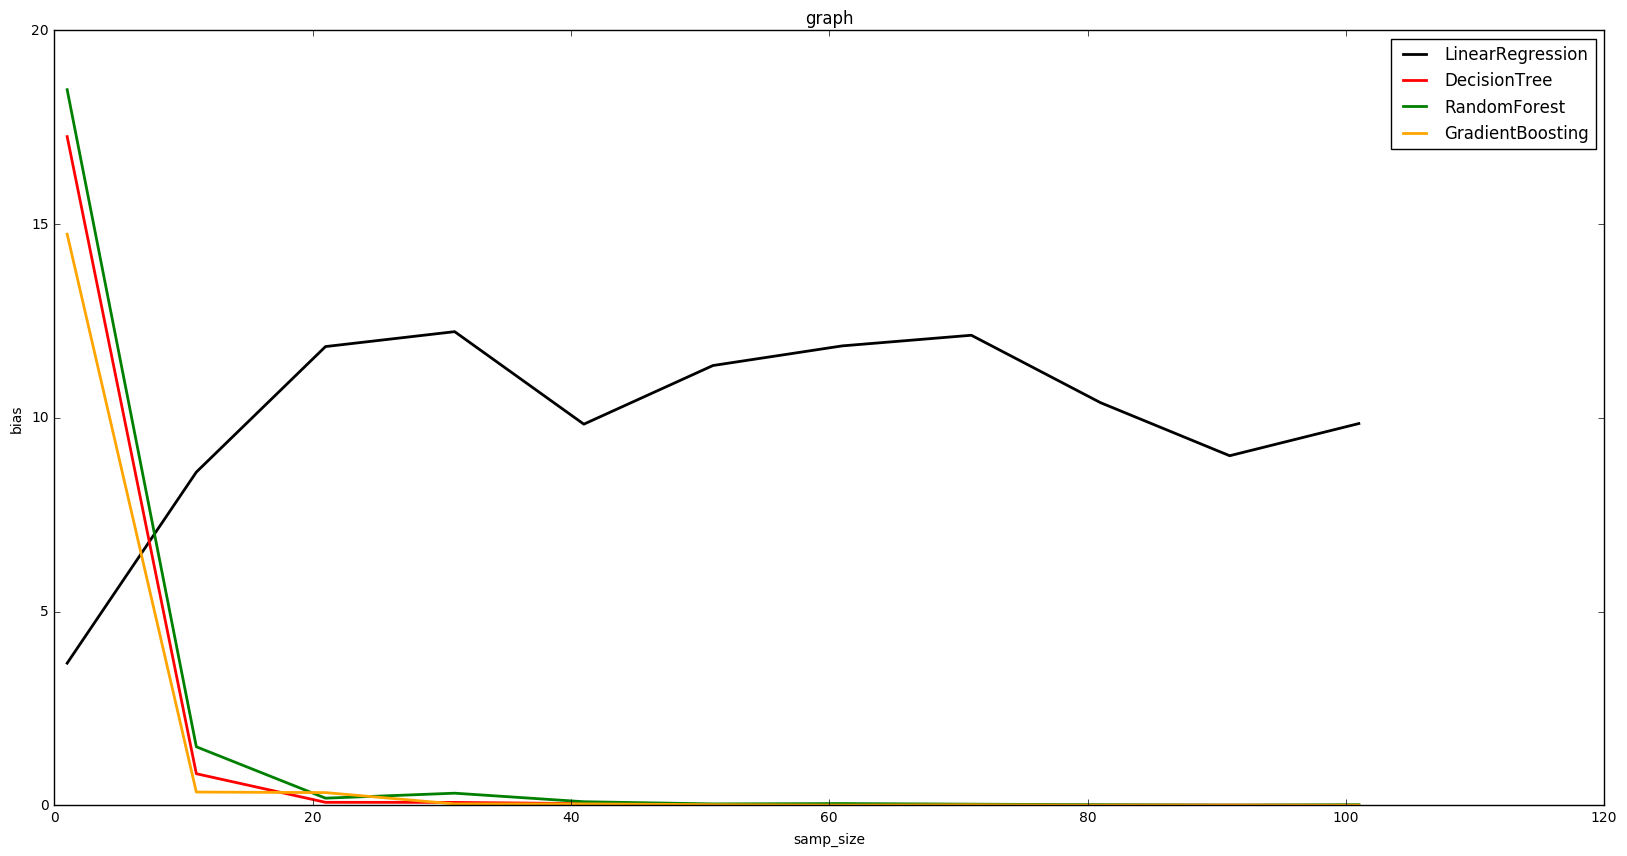

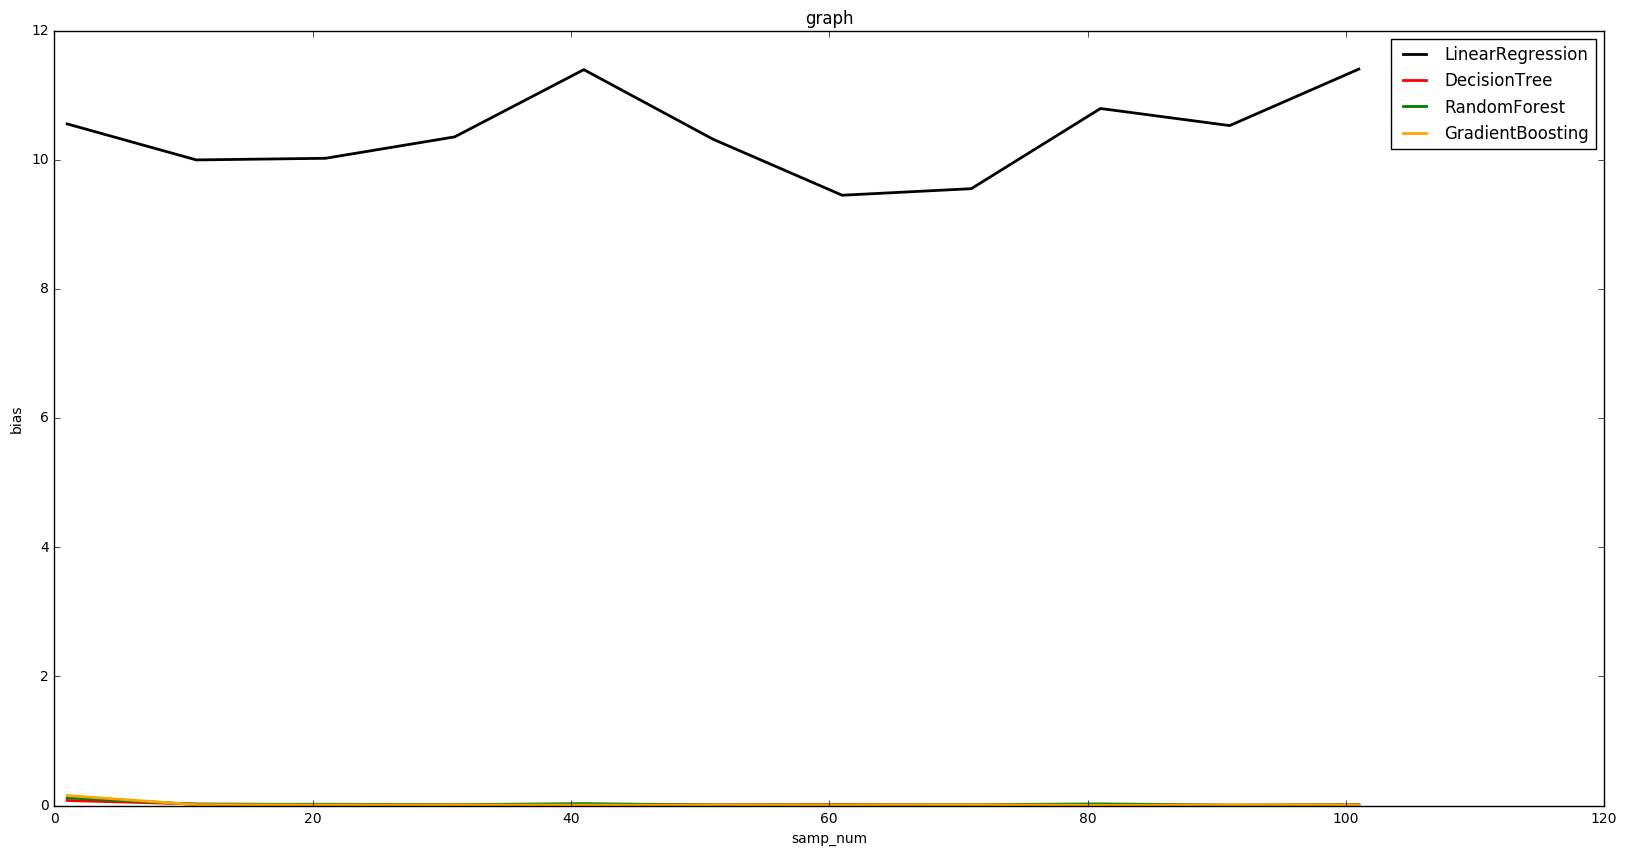

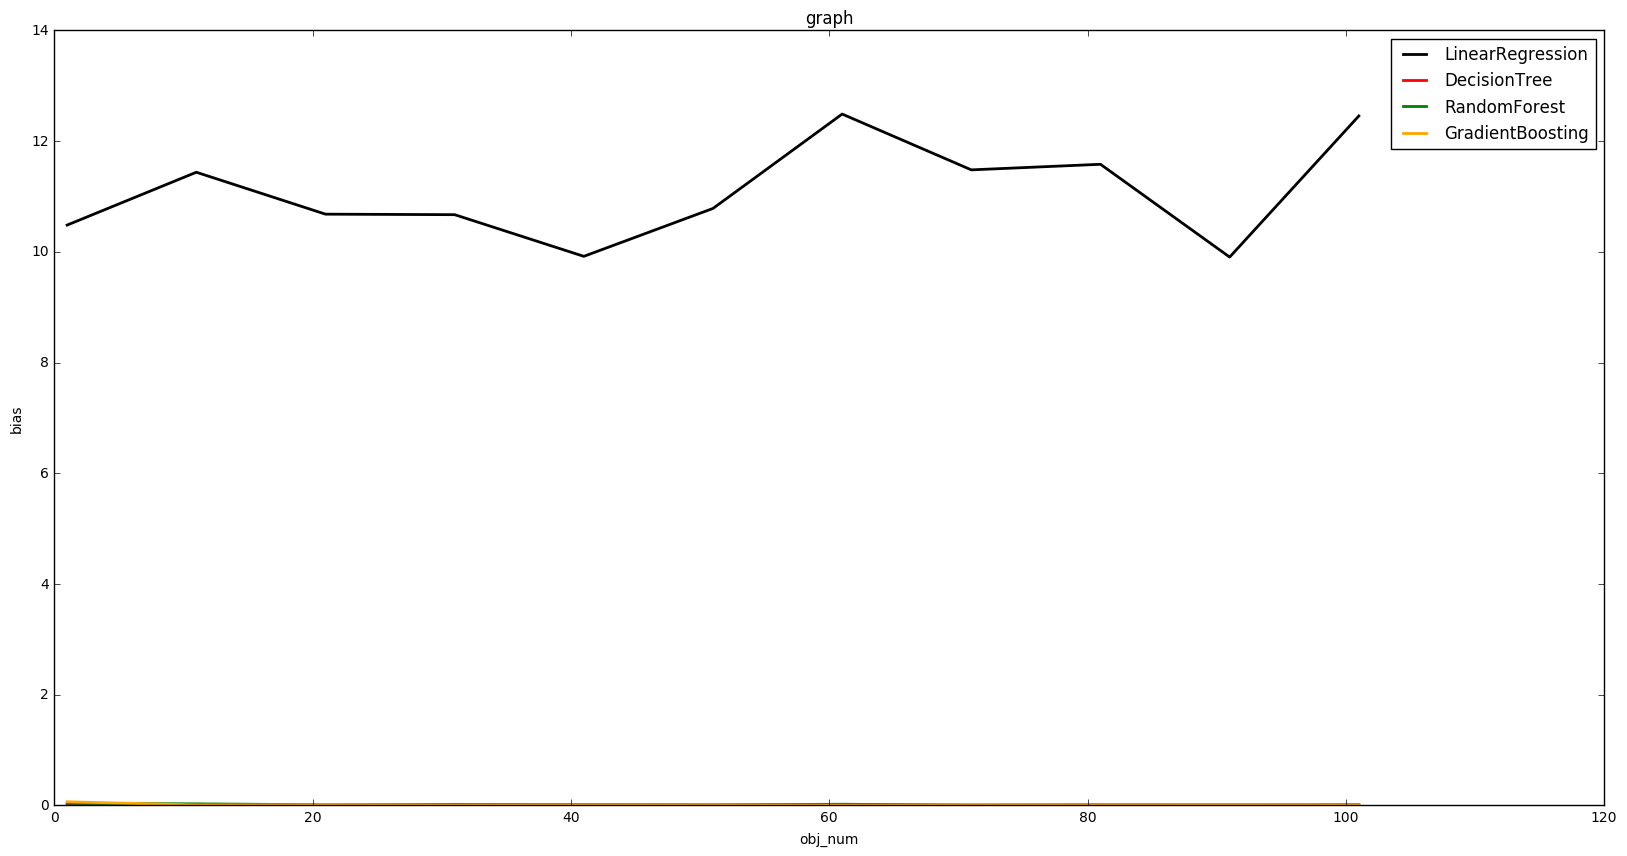

In [15]:
algs = ["LinearRegression", "DecisionTree", "RandomForest", "GradientBoosting"]
colors = ["black", "red", "green", "orange"]
counts = [i for i in range(1, 102, 10)]
param_names = ['samp_size', 'samp_num', 'obj_num']
params_stat = [samp_size_stat, samp_num_stat, obj_num_stat]

for idx_p, param in enumerate(params_stat):
#     зависимости bias от количества параметров
    fig, ax = plt.subplots(figsize=(20, 10))
#     plt.xlim([0, 1])
    for idx_r, alg in enumerate(algs):
        plt.plot(counts, np.array(params_stat[idx_p][idx_r])[:, 0], c=colors[idx_r], linewidth=2, label=algs[idx_r])
    plt.xlabel(param_names[idx_p])
    plt.ylabel('bias')
    plt.title('graph')
    plt.legend()
    

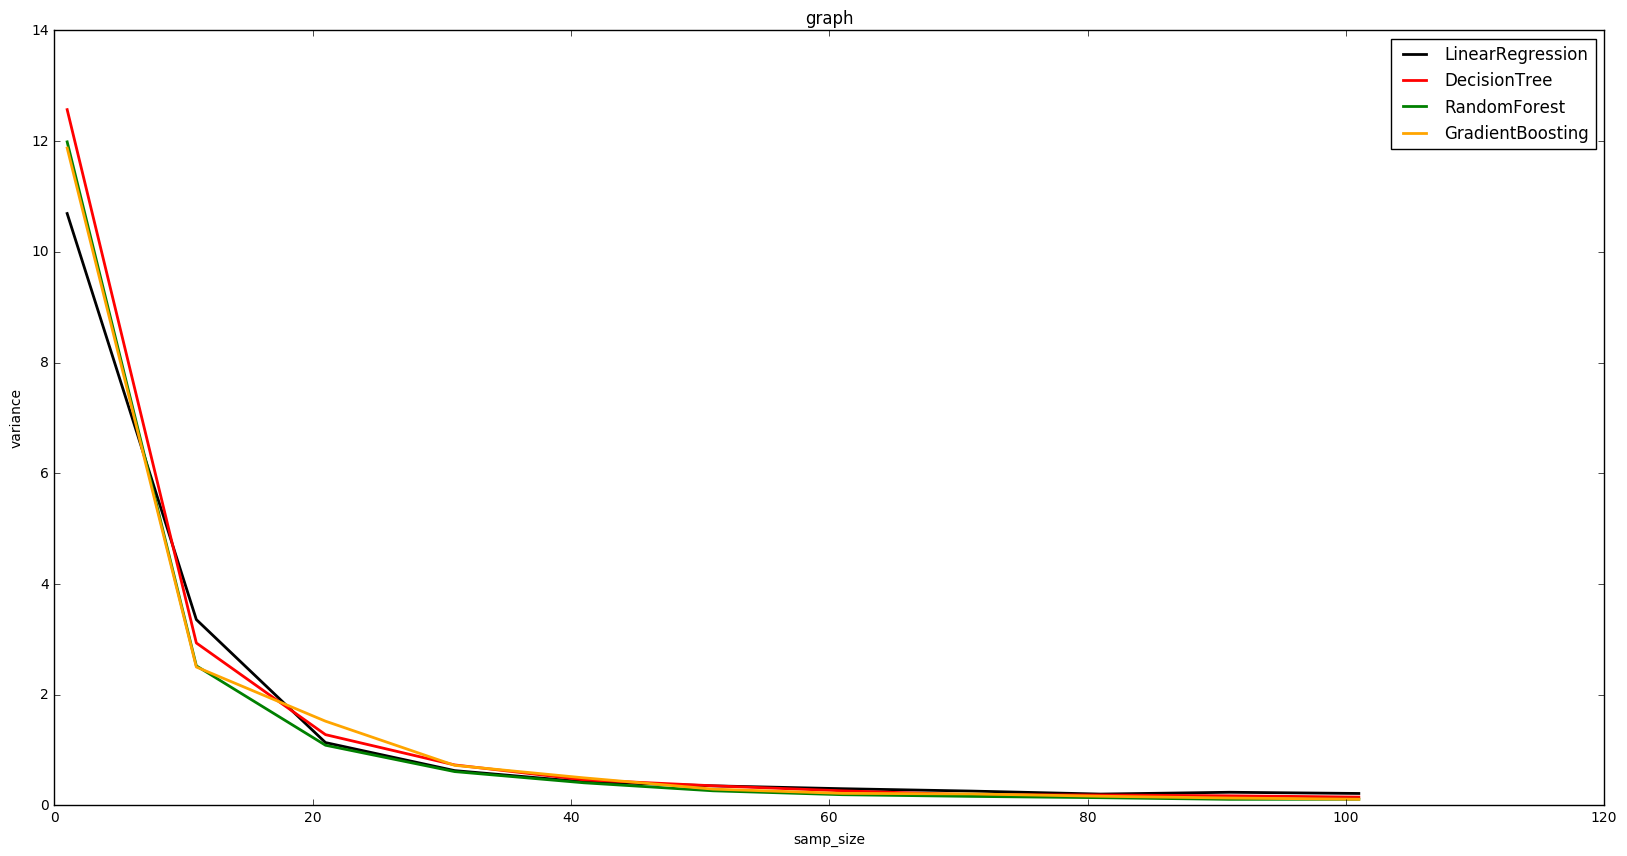

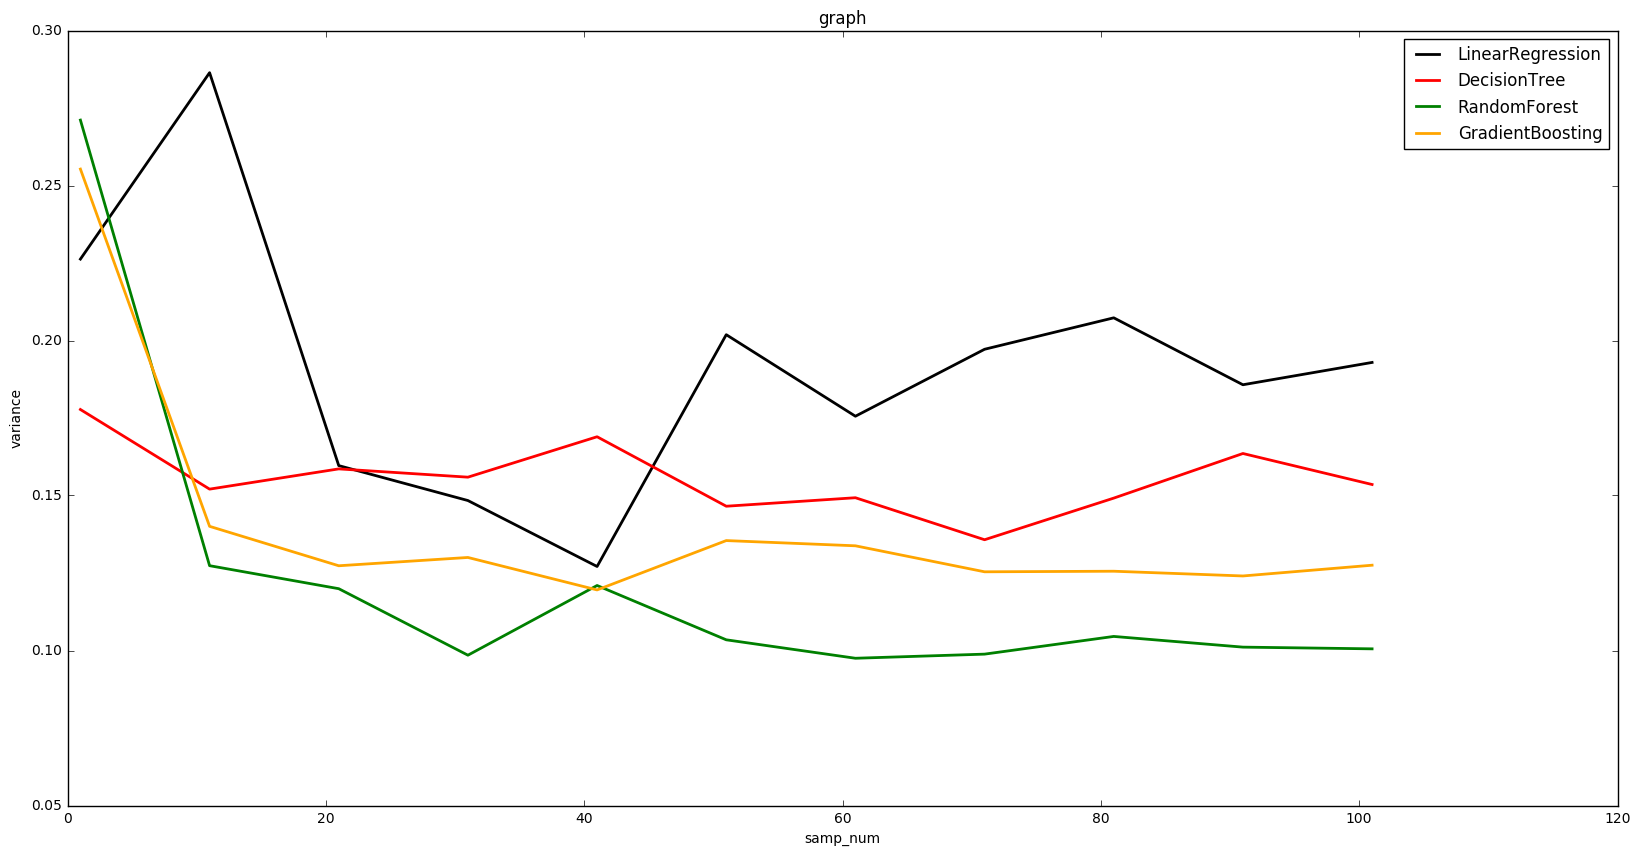

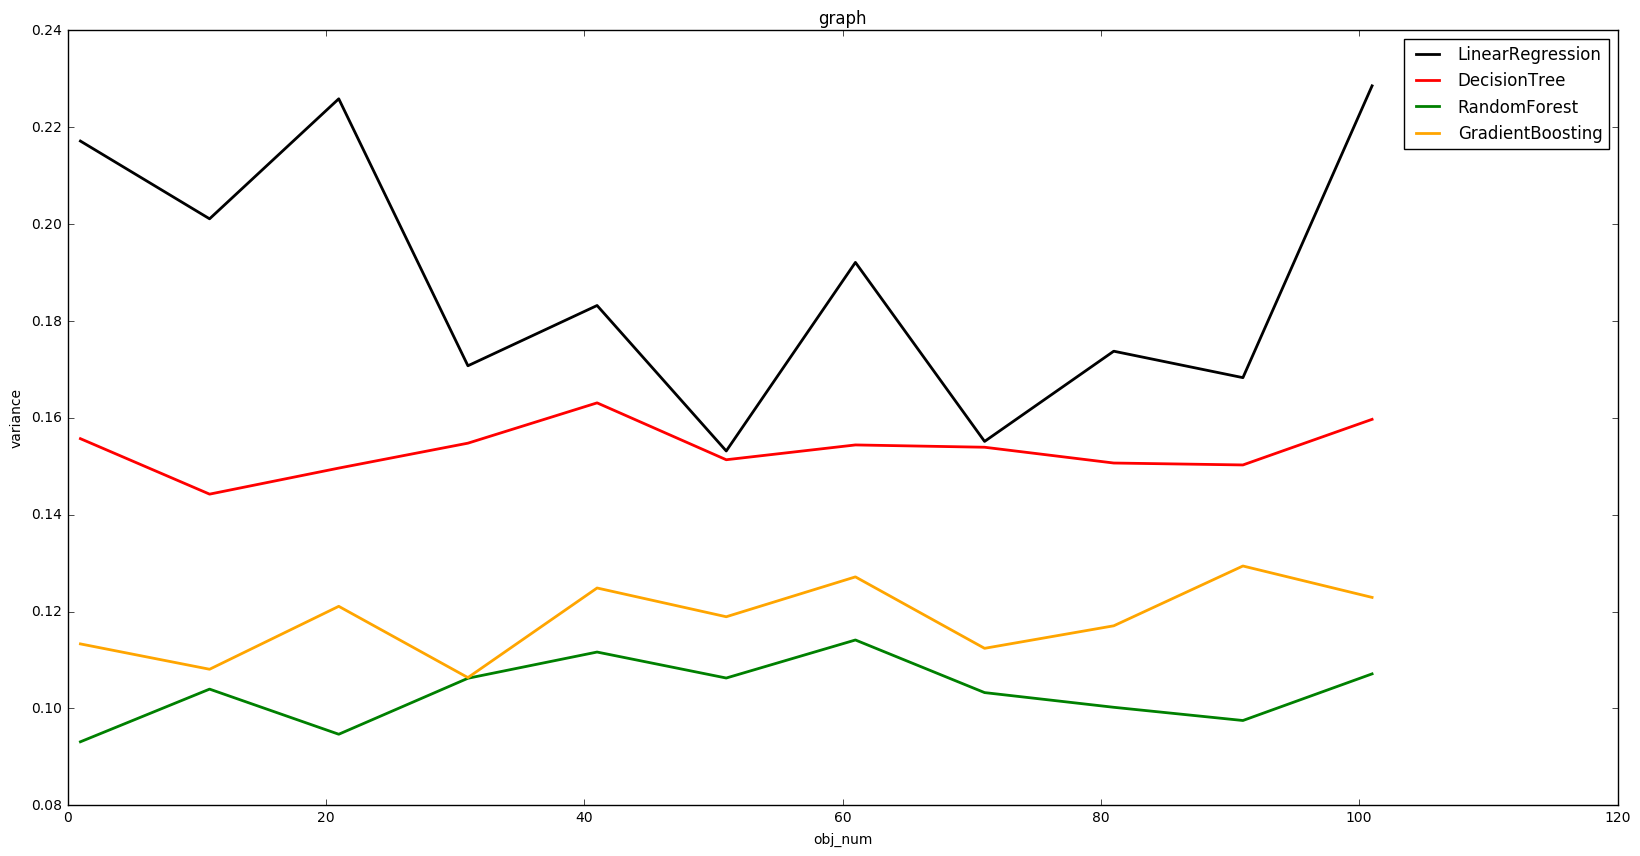

In [16]:
for idx_p, param in enumerate(params_stat):
#     зависимости variance от количества параметров
    fig, ax = plt.subplots(figsize=(20, 10))
#     plt.xlim([0, 1])
    for idx_r, alg in enumerate(algs):
        plt.plot(counts, np.array(params_stat[idx_p][idx_r])[:, 1], c=colors[idx_r], linewidth=2, label=algs[idx_r])
    plt.xlabel(param_names[idx_p])
    plt.ylabel('variance')
    plt.title('graph')
    plt.legend()


Параметры снижают дисперсию оценки bias для всех алгоритмов, кроме LinearRegression. Вероятно, при наличии большего количества точек и bias LR выйдет на число (график перестанет скакать). Obj_num практически совсем не влияет на разброс bias для алгоритмов.

samp_size оказыват большое влияние на разброс variance всех без исключения алгоритмов, оценки сходятся к нулю очень быстро. samp_num вцелом оказывает заметное влияние на раброс variance. Видно, что амплитуда колебания графиков снижается с ростом парамера (всех меньше влияние, снова, на LR) Obj_num не оказывает практически никакого действия на LR, GB и RF, и чуть снижает разброс оценок variance для DT .

### II. Решающие деревья своими руками
#### Задача 3.
В этой части вам нужно реализовать свой класс для обучения решающего дерева в задаче бинарной классификации с возможностью обработки вещественных и категориальных признаков.

__7 (0.5 балла)__

Реализуйте следующую функцию:

In [102]:
def get_gini_for_threshold(permutation, target_vector, min_samples_leaf, thresholds_idx):
    l = target_vector[permutation][:thresholds_idx + 1]
    r = target_vector[permutation][thresholds_idx + 1:]
#         есть размеры.
    if (l.shape[0] < min_samples_leaf) or (r.shape[0] < min_samples_leaf):
        return -10 ** 10
    else:
        p_1_l = np.count_nonzero(l) / l.shape[0]
        p_1_r = np.count_nonzero(r) / r.shape[0]
        p_0_l = 1 - p_1_l
        p_0_r = 1 - p_1_r

        return -(l.shape[0] / target_vector.shape[0]) * (1 - p_1_l ** 2 - p_0_l ** 2) - (r.shape[0] / target_vector.shape[0]) * (1 - p_1_r ** 2 - p_0_r ** 2)


In [103]:
def find_best_split(feature_vector, target_vector, min_samples_leaf=0):
    permutation = feature_vector.argsort()
    thresholds = np.unique(feature_vector[permutation][:-1:], return_index=True, return_counts=True)
#   thresholds = np.unique(feature_vector[permutation][1::], return_index=True, return_counts=True)
    
    thresholds_idx = thresholds[1] + (thresholds[2] - 1)
    get_ginis = np.vectorize(get_gini_for_threshold, excluded=['permutation', 'target_vector', 'min_samples_leaf'])
    ginis = get_ginis(permutation=permutation, target_vector=target_vector, min_samples_leaf=min_samples_leaf, thresholds_idx=thresholds_idx)
        
    return thresholds[0], ginis, feature_vector[permutation][thresholds_idx[np.array(ginis).argmax()]], np.array(ginis).max(), thresholds_idx[np.array(ginis).argmax()]  # немного модернизировал
    
    


Параметры:
* feature_vector: вещественнозначный вектор значений признака (np.array)
* target_vector: вектор классов объектов (np.array). len(feature_vector)==len(target_vector).

Возвращаемые значения:
* thresholds: отсортированный по возрастанию вектор со всеми возможными порогами, по которым объекты можно разделить на две различные подвыборки, или поддерева (np.array)
* ginis: вектор со значениями критерия Джини для каждого из порогов в thresholds. (np.array, len(ginis)==len(thresholds))
* оптимальный порог (число)
* оптимальное значение критерия Джини (число)

Под критерием Джини здесь подразумевается следующая функция:
$$Q(R) = -\frac {|R_l|}{|R|}H(R_l) -\frac {|R_r|}{|R|}H(R_r),$$
$R$ - множество объектов, $R_l$ и $R_r$ - объекты, попавшие в левое и правое поддерево, $H(R) = 1-p_1^2-p_0^2$, $p_1$, $p_0$ - доля объектов класса 1 и 0 соответственно.

Указания:
* Пороги, приводящие к попаданию в одно из поддеревьев пустого множества объектов, не рассматриваются.
* За наличие в функции циклов балл будет снижен. Векторизуйте! :)

__8 (0.5 балла)__
Загрузите таблицу [students.csv](https://drive.google.com/file/d/0B2zoFVYw1rN3a0d0Zm43TzQ4aUU/view?usp=sharing) (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах,а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог - значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте scatter-графики "значение признака - класс" для всех пяти признаков.

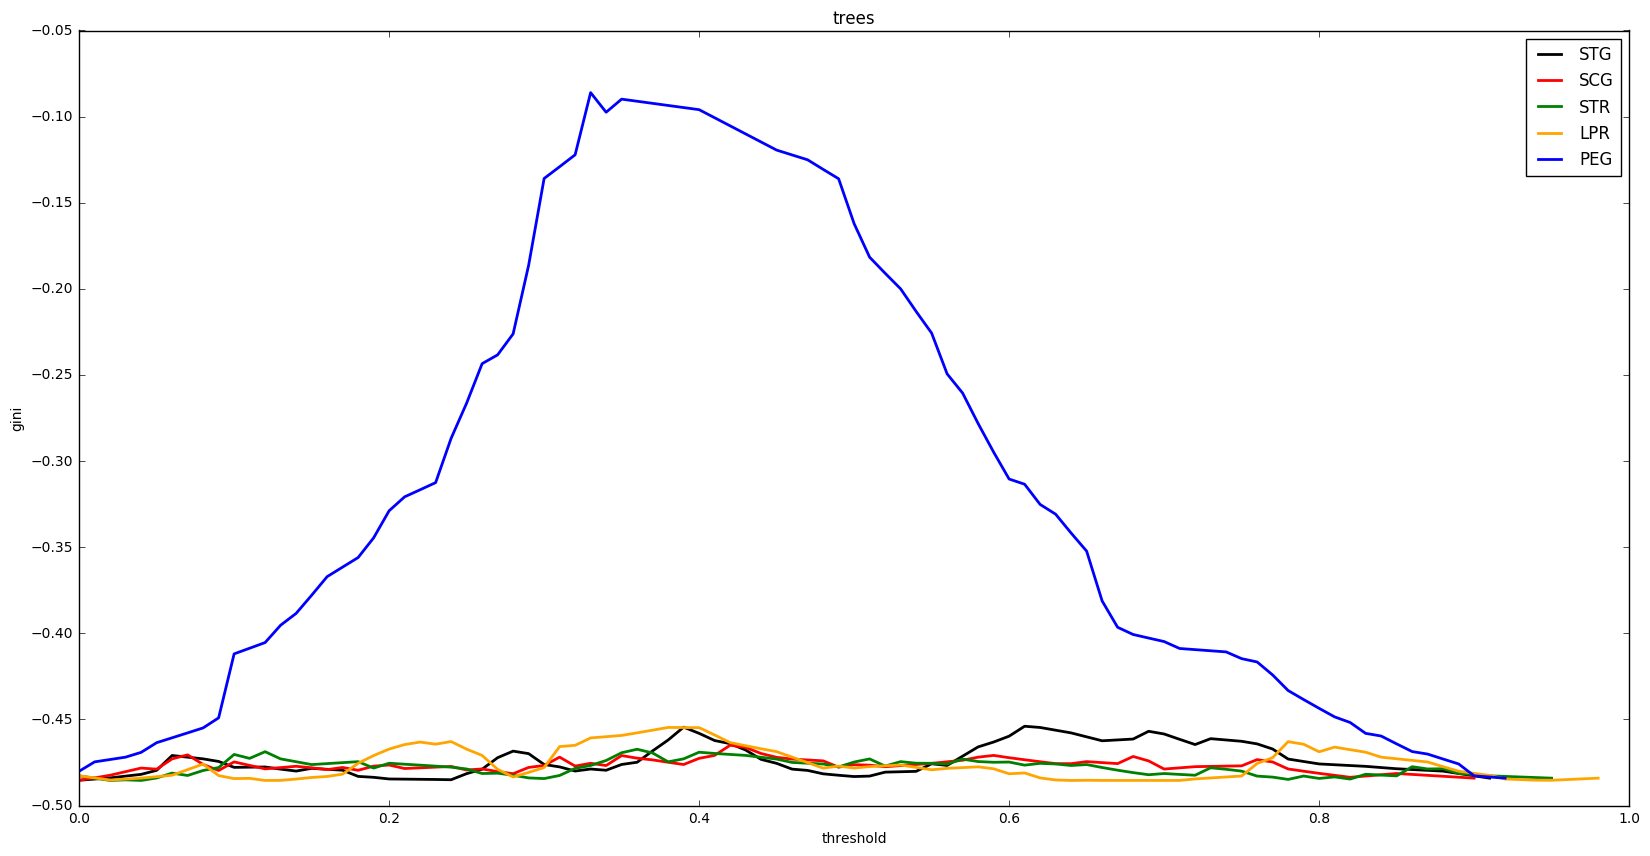

In [104]:
### ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
X = pd.read_csv('students.csv')
y = X[' UNS']
X = X.drop([' UNS'], axis=1)

    
fig, ax = plt.subplots(figsize=(20, 10))
features = ["STG", "SCG", "STR", "LPR", "PEG"]
colors = ["black", "red", "green", "orange", "blue"]
for idx, column in enumerate(X.columns):
    best_split = find_best_split(X[column], y)
#     patch.Patch(color=colors[idx], label=features[idx])
    plt.plot(best_split[0], best_split[1], c=colors[idx], linewidth=2, label=features[idx])
plt.xlabel('threshold')
plt.ylabel('gini')
plt.legend()
# plt.plot(linspace, np.sum(np.array(predictions), axis=0) / samples_num, c='black', linewidth=2)

plt.title('trees')

In [105]:
X.shape

(258, 5)

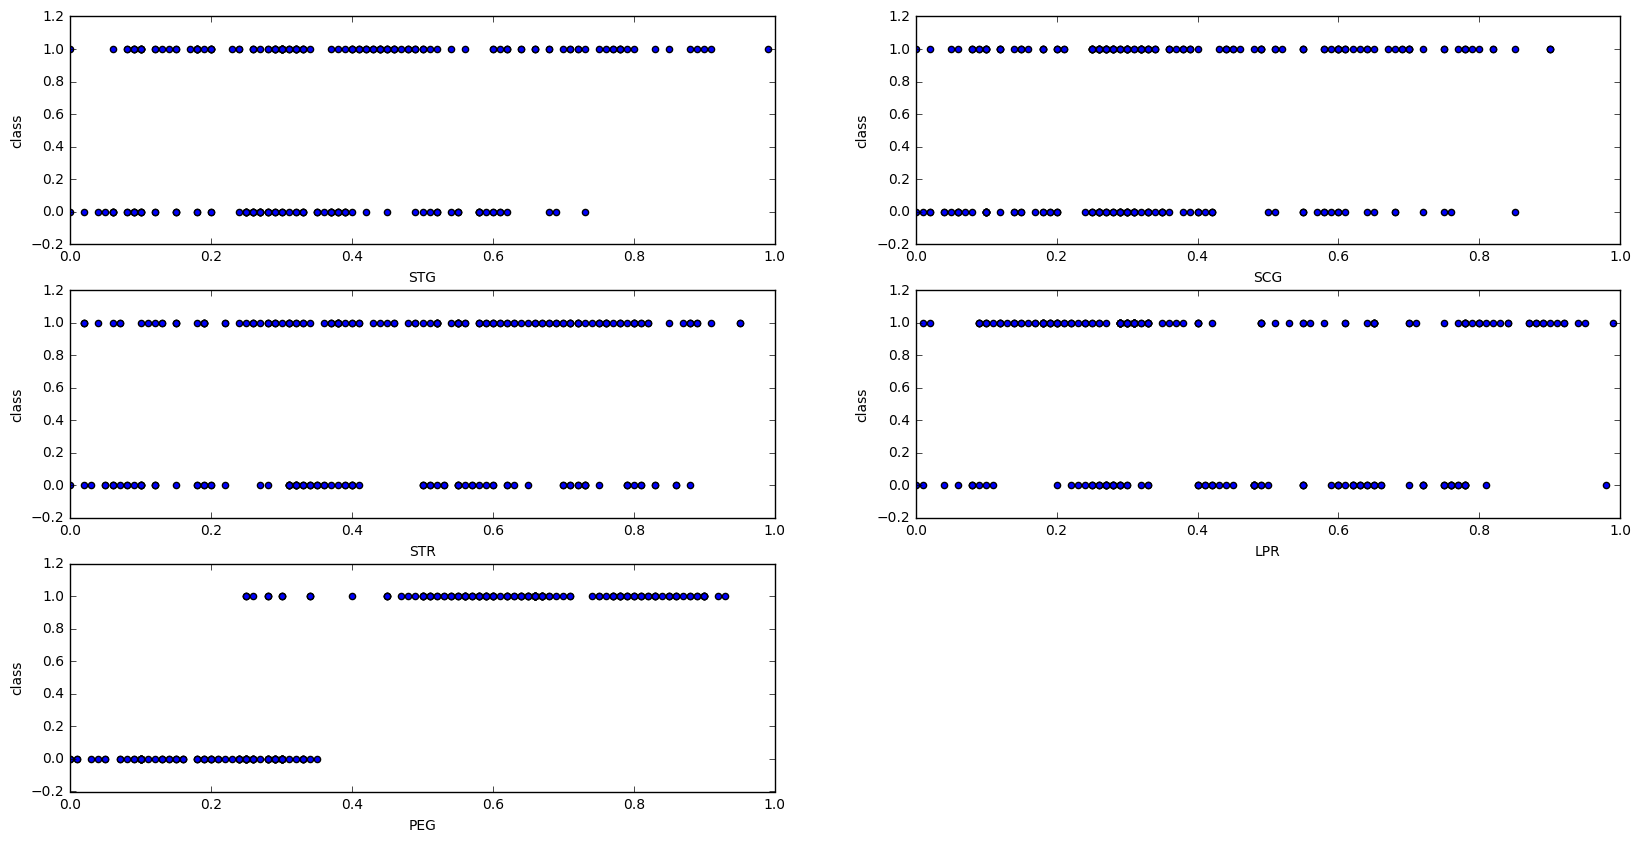

In [106]:
fig, ax = plt.subplots(figsize=(20, 10))
for idx, column in enumerate(X.columns):
    plt.subplot(3, 2, idx+1)
    plt.xlim([0, 1])
    plt.scatter(X[column], y, s=20)
    plt.ylabel("class")
    plt.xlabel(features[idx])

__9 (0.5 балла)__ Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой scatter-графиков? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

(・・ ) ?

Согласно кривым, всех лучше делится выборка по признаку (PEG), который соответствует синей линии.

Полностью согласуется, на scatter графике для PEG видно что выборка очень круто делиться по порогу ~0.4, так что справа остается только первый класс, а слева нулевой с небольшими вкраплениями первого. Для хороших признаков кривая принимает значения близкие к максимальным на большом количестве порогов (выглядит как горка или выпукля вверх). Имеет значительную разницу между своим максимальным и минимальным знаениями джини для разных порогов. Для плохих - кривая колбасится в окрестности какого-то, не очень хорошего значения критерия Джини и имеет маленькую амплитуду. Согласно графику, к плохим я отнесу красную (SCG), черную(STG), зеленую(STR) и желтую(LPR) линии (по ним выборка делится плохо и графики, у них, вцелом, очень похожи).К отличным - синюю(PEG).

__10 (1.5 балла).__
Реализуйте класс для обучения решающих деревьев. Мы не будем усложнять класс множеством параметров, как в sklearn. Требования к классу:
* Единственный параметр дерева - вектор, задающий типы признаков: если в позиции i стоит 0, то с признаком номер i нужно работать как с вещественным, если 1 - как с категориальным.
* Чтобы классификатор "распознавался" функциями sklearn, необходимо наследовать его от BaseEstimator. 
* У класса должно быть реализовано два метода: fit и predict. Метод fit принимает на вход двумерный np.array - матрицу объекты-признаки и одномерный вектор ответов y, внутри метода происходит обучение дерева. Метод predict принимает на вход двумерную матрицу объекты-признаки (np.array) и возвращает вектор предсказанных классов (одномерный np.array) для всех объектов.
* Построение дерева должно осуществляться согласно базовому жадному алгоритму, предложенному в [лекции](https://github.com/esokolov/ml-course-hse/blob/master/2016-fall/lecture-notes/lecture07-trees.pdf) в разделе "Построение дерева". Выбор лучшего разбиения необходимо производить по критерию Джини. Критерий останова: все объекты в листе относятся к одному классу. Ответ в листе: класс объектов, находящихся в нем. Для категориальных признаков необходимо выполнить преобразование, описанное в лекции в разделе "Учет категориальных признаков".

Далее будут даны рекомендации по реализации решающего дерева. Им следовать необязательно: например, вы можете использовать свою структуру для хранения дерева.
* Дерево можно хранить в виде сложенных списков. Каждая внутренняя вершина дерева - список node длины 4: node[0] хранит индекс признака, по которому в данной вершине делается разбиение, node[1] - порог для разбиения, если i-й признак вещественный, и множество значений признака, с которыми объект попадает в левое поддерево, если i-й признак категориальный, node[2] - левое поддерево (список) и node[3] - правое поддерево (список). В листьях node состоит из единственного элемента - ответа, возвращаемого в этом листе. Пример простого дерева, разделяющего выборку по нулевому признаку по порогу 5 на два листа, возвращающих класс 0 и 1: [0, 5, [0], [1]]. Если в левом поддереве корня выполнять разделение по 1-му признаку по порогу 7: [0, 5, [1, 7, [0], [1]], [1]].
* Внутри функции fit определяется рекурсивная функция fit_node(subX, suby, node), принимающая матрицу объекты-признаки subX и ответы на этих объектах suby, а также ссылку на пустой список node - вершину, в которой необходимо выполнить разбиение на две подвыборки. Функция fit_node должна заполнить этот список вызовами node.append(.....). Если suby состоит из одинаковых значений, нужно добавить к node это значение и выйти. Иначе выполнить перебор по всем признакам: для каждого признака с помощью функции find_best_split найти наилучшее разбиение и выбрать признак, дающий максимальное значение критерия Джини. Для категориальных признаков нужно выполнить специальное преобразование (см. лекцию). Вершину нужно заполнить индексом выбранного признака, порогом или множеством значений (задающих разбиение), а затем рекурсивно вызвать fit_node для левого и правого поддерева.
* Внутри функции predict также определяется рекурсивная функция predict_node(x, node), принимающая один объект и вершину. Она проверяет, является ли node листом (это можно определить по длине списка), если да - возвращает node[0], т. е. класс, задаваемый этим листом. Иначе функция определяет, к какому поддереву относится объект, и рекурсивно вызывает себя для этого поддерева.
* В процессе тестирования кода может оказаться, что рекурсивные вызовы повторяются бесконечно. Так происходит, если в одно из поддеревьев попадает пустая подвыборка. Этого быть не должно: пороги, при которых все объекты попадают в одно поддерево, не рассматриваются (см. указания к функции find_best_split).
* Дерево должно давать единичную долю верных ответов на обучающей выборке.
* Протестировать, правильно ли выполняется преобразование категориальных признаков, можно на простой синтетической выборке с одним категориальным признаком, по которому объекты идеально делятся на два класса, и при этом такого эффекта нельзя достичь установкой порога на этот признак.

In [108]:
### Шаблон класса, следующего рекомендациям
class DecisionTree(BaseEstimator):
    def __init__(self, types, max_depth=None, min_samples_split=2, min_samples_leaf=1):
        self._tree = []
        self.types = types
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.current_depth = 0

    def fit(self, X, y):
        self._tree = []
#         чтоб аж как в sklearn v 0.18:
        self.min_samples_split = ceil(self.min_samples_split * y.shape[0]) if type(self.min_samples_split) is float else self.min_samples_split
        self.min_samples_leaf = ceil(self.min_samples_leaf * y.shape[0]) if type(self.min_samples_leaf) is float else self.min_samples_leaf
        def fit_node(subX, suby, node, c_depth):
     
            if (self.current_depth == self.max_depth) or (np.unique(suby).shape[0] == 1) or (suby.shape[0] < self.min_samples_split): #Если у состоит из объектов одинакового класса STOP
                node.append(np.random.choice(suby))
            else:
                c_depth += 1
                self.current_depth = max(self.current_depth, c_depth)
                subX_for_iteration = np.copy(subX)
                cat_vals_dicts = [dict() for i in range(len(self.types))]
                # Пилим учет категориальных признаков
                #########################################
                def set_cat_vals(X, y, i):
                    permutation = X.argsort()
                    unique, indices, counts = np.unique(X[permutation], return_counts=True, return_index=True)
                    # Достаем срез Y где значение кат признака из юник
                    y_first_class_counts = []
                    last_idx = 0
                    for idx in (indices + (counts - 1)):
                        y_first_class_counts.append(np.count_nonzero(y[permutation][last_idx:idx + 1:]))
                        last_idx += idx + 1 
                    prob_first_class = np.array(y_first_class_counts) / counts
                    prob_permutation = prob_first_class.argsort()
                    unique = unique[prob_permutation] #отсортированные значения по вероятности (теперь надо заменить значения признака на i его в юнике)
                    for j, cat_value in enumerate(unique): 
                        cat_vals_dicts[i][cat_value] = j

                    def set_i_vals_to_column(x):
                        return cat_vals_dicts[i].get(x)


                    vfunc = np.vectorize(set_i_vals_to_column)
                    return vfunc(X)
                ######################################################
                for i, value in enumerate(self.types):
                    if value:
                        subX_for_iteration[:, i] = set_cat_vals(subX_for_iteration[:, i], y, i)
#                         print(subX[:, i])
                        
                splits = []
                for feature_i in range(subX_for_iteration.shape[1]):
                    splits.append([feature_i] + list(find_best_split(subX_for_iteration[:, feature_i], suby, self.min_samples_leaf)[2:]))
#                 print(splits)
                best_split = splits[np.array(splits).argmax(axis=0)[2]] #[i, t] для лучшего разбиения
                best_i, best_t, best_t_idx = best_split[0], best_split[1], best_split[3] #[i, t] для лучшего разбиения

                node.append(best_i) #Заполнили номером признака
                node.append([key for key, val in cat_vals_dicts[best_i].items() if val <= best_t] if self.types[i] else best_t)
                node.append([]) # левое поддерево
                node.append([]) # правое поддерево
                perm = subX_for_iteration[:, best_i].argsort()
                
                l_subX = subX[perm][:best_t_idx + 1]
                l_suby = suby[perm][:best_t_idx + 1]
                r_subX = subX[perm][best_t_idx + 1:]
                r_suby = suby[perm][best_t_idx + 1:]
#                 print(l_suby.shape[0], r_subX.shape[0])
                
                fit_node(l_subX, l_suby, node[2], c_depth)
                fit_node(r_subX, r_suby, node[3], c_depth)

        
        fit_node(X, y, self._tree, self.current_depth)
    
    def predict(self, X):
        def predict_node(x, node):
            if len(node) == 1:
                return node[0]
            else:
                if type(node[1]) is list:
                    return predict_node(x, node[2]) if x[node[0]] in node[1] else predict_node(x, node[3])
                else:
                    return predict_node(x, node[2]) if x[node[0]] <= node[1] else predict_node(x, node[3])
                

        predicted = []
        for x in X:
            predicted.append(predict_node(x, self._tree))
        return np.array(predicted)

__11 (0.5 балла)__ Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). Вам нужно скачать таблицу agaricus-lepiota.data (из [Data Folder](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/)), прочитать ее с помощью pandas, применить к каждому столбцу LabelEncoder (из sklearn), чтобы преобразовать строковые имена категорий в натуральные числа. Первый столбец - это целевая переменная (e-edible, p-poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что - классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

У вас должно получиться значение accuracy, равное единице (или очень близкое к единице), и не очень глубокое дерево.

In [109]:
# a = np.array([[0,0,1],[0,1,3],[1,2,0],[1,1,0]])#,[3,1],[2,1], [1,2],[5,7]])
# b = np.array([1,1,0,1])#, 0,0,0])
# dt = DecisionTree([1,1,1])
# dt.fit(a,b)
# type(np.random.choice(b))

In [110]:
# dt.current_depth

In [111]:
type(5) is float

False

In [112]:
X = pd.read_csv('agaricus-lepiota.data', header=None)
pd.options.display.max_columns = 30
lenc = LabelEncoder()
for feature in X.columns:
    X[feature] = lenc.fit_transform(X[feature])
# X = lenc.fit_transform(X)
X.head()
y = X[0]
X = X.drop([0], axis=1)
X.head(1)

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22
0,5,2,4,1,6,1,0,1,4,0,3,2,2,7,7,0,2,1,4,2,3,5


In [113]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

In [114]:
%%time
DT = DecisionTree(types=[1 for i in range(X_train.shape[1])])

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 44.6 µs


In [115]:
%%time
DT.fit(np.array(X_train), np.array(y_train))


CPU times: user 288 ms, sys: 0 ns, total: 288 ms
Wall time: 289 ms


In [116]:
X.shape

(8124, 22)

In [117]:
predictions = DT.predict(np.array(X_test))

# ТЕСТИРУЮ:
print(accuracy_score(predictions, y_test))
# predictions[0]

1.0


In [118]:
DT.current_depth

8

In [119]:
# import pprint
# stuff = ['spam', 'eggs', 'lumberjack', 'knights', 'ni']
# stuff.insert(0, stuff[:])
# pp = pprint.PrettyPrinter(indent=1, depth=100)
DT._tree
# DT._tree

[4,
 [0, 3, 4, 5],
 [4,
  [4],
  [1],
  [19,
   [4, 5],
   [3, [0], [0], [1]],
   [16,
    [3],
    [1],
    [0,
     [0, 2, 3, 4, 5],
     [7, [1], [12, [3], [1], [20, [4, 5], [0], [1]]], [0]],
     [1]]]]],
 [1]]

In [120]:
не_моё_дерево = DecisionTreeClassifier(max_depth=2, min_samples_split=1)
не_моё_дерево.fit(X_train, y_train)
предсказания = не_моё_дерево.predict(np.array(X_test))

# predictions
print(accuracy_score(предсказания, y_test))

0.907927129493


__11* (1 доп. балл)__

Реализуйте в классе DecisionTree поддержку параметров max_depth, min_samples_split и min_samples_leaf по аналогии с DecisionTreeClassifier. Постройте графики зависимости качества предсказания в зависимости от этих параметров для набора данных tic-tac-toe (см. следующий пункт).

In [36]:
X_tic_tac_toe = pd.read_csv('tic-tac-toe.csv', header=None)
lenc = LabelEncoder()
for feature in X_tic_tac_toe.columns:
    X_tic_tac_toe[feature] = lenc.fit_transform(X_tic_tac_toe[feature])

y_tic_tac_toe = X_tic_tac_toe[X_tic_tac_toe.shape[1] - 1]
X_tic_tac_toe = X_tic_tac_toe.drop([X_tic_tac_toe.shape[1] - 1], 1)

X_train, X_test, y_train, y_test = train_test_split(X_tic_tac_toe, y_tic_tac_toe, test_size=0.5, random_state=42)

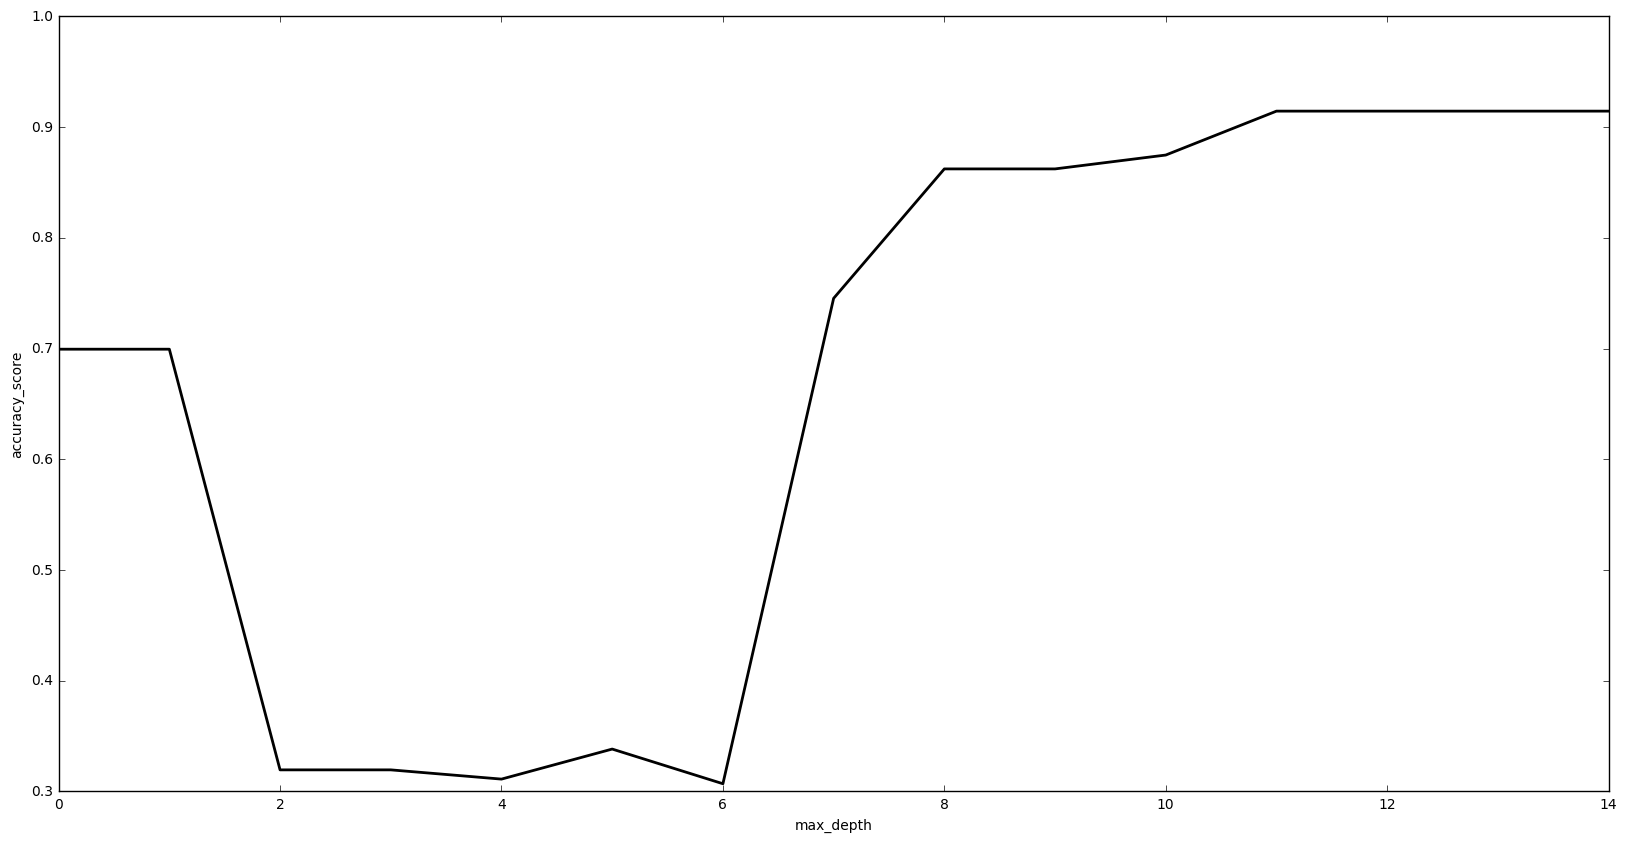

In [37]:
depths = [depth for depth in range(15)]
pred_for_max_depth = []

for depth in depths: #по умолчанию на этих данных строится глубины 10, дальше на константу выйдет 
    DT = DecisionTree([1 for i in range(X_tic_tac_toe.shape[1])], max_depth=depth)
    DT.fit(np.array(X_train), np.array(y_train))
    pred_for_max_depth += [accuracy_score(DT.predict(np.array(X_test)), y_test)]
    
fig, ax = plt.subplots(figsize=(20, 10))
plt.ylabel('accuracy_score')
plt.xlabel('max_depth')
plt.plot(depths, pred_for_max_depth, c='black', linewidth=2)

CPU times: user 1min 29s, sys: 24 ms, total: 1min 29s
Wall time: 1min 29s


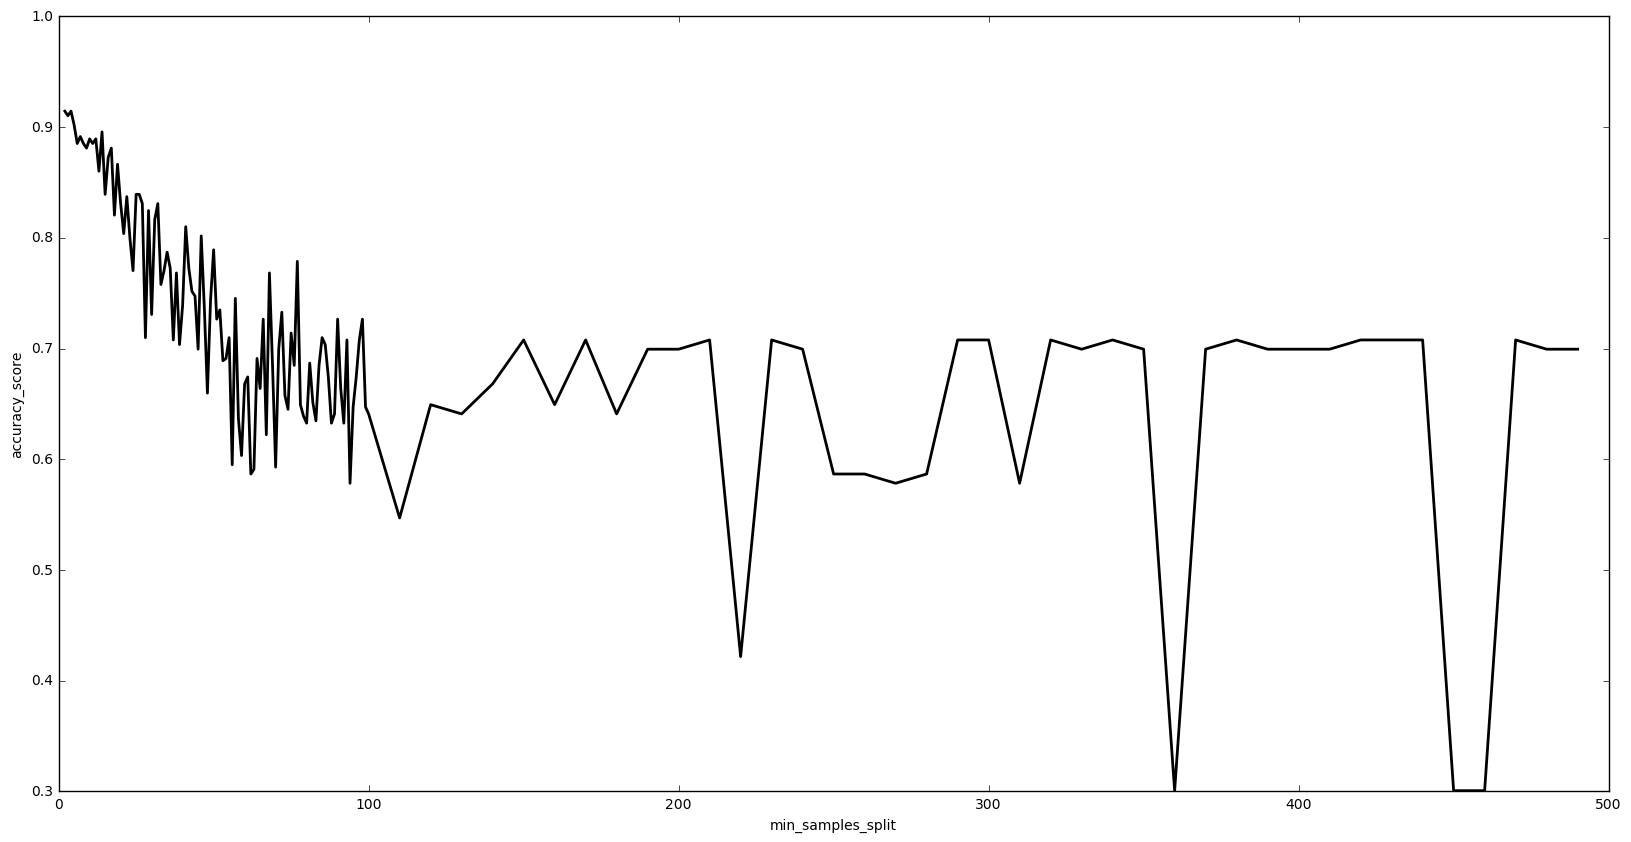

In [39]:
%%time
min_samp = [amount for amount in range(2, 100)] + [amount for amount in range(100, 500, 10)] # до сотки по единичному шагу, дальше по десяти
pred_for_min_samp_split = []
pred_for_min_samp_leaf = []

for min_s in min_samp: 
    DT = DecisionTree([1 for i in range(X_tic_tac_toe.shape[1])], min_samples_split=min_s)
    DT.fit(np.array(X_train), np.array(y_train))
    pred_for_min_samp_split += [accuracy_score(DT.predict(np.array(X_test)), y_test)]
    DT = DecisionTree([1 for i in range(X_tic_tac_toe.shape[1])], min_samples_leaf=min_s)
    DT.fit(np.array(X_train), np.array(y_train))
    pred_for_min_samp_leaf += [accuracy_score(DT.predict(np.array(X_test)), y_test)]
    
fig, ax = plt.subplots(figsize=(20, 10))
plt.ylabel('accuracy_score')
plt.xlabel('min_samples_split')
plt.plot(min_samp, pred_for_min_samp_split, c='black', linewidth=2)

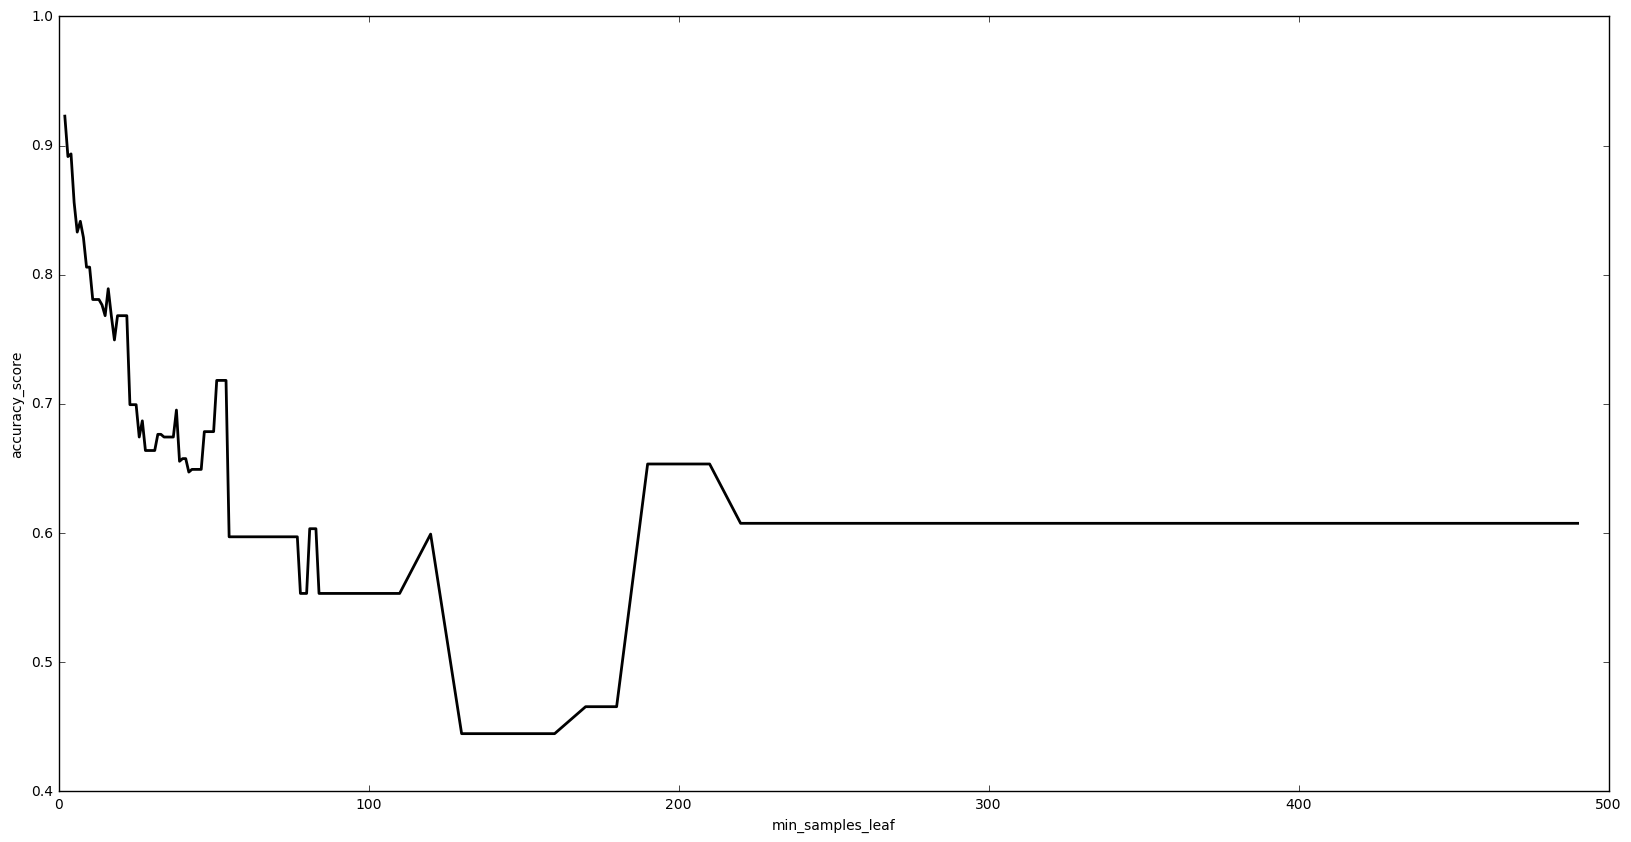

In [41]:
fig, ax = plt.subplots(figsize=(20, 10))
plt.ylabel('accuracy_score')
plt.xlabel('min_samples_leaf')
plt.plot(min_samp, pred_for_min_samp_leaf, c='black', linewidth=2)

__12 (1 балл)__

Загрузите следующие наборы данных (напомним, что pandas умеет загружать файлы по url, в нашем случае это файл \*.data), предварительно ознакомившись с описанием признаков и целевой переменной в каждом из них (она записаны в Data Folder, в файле *.names): 
* [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom) (загрузили в предыдущем пункте, классы записаны в нулевом столбце),
* [tic-rac-toe](https://archive.ics.uci.edu/ml/datasets/Tic-Tac-Toe+Endgame) (классы записаны в последнем столбце)
* [cars](https://archive.ics.uci.edu/ml/datasets/Car+Evaluation) (классы записаны в последнем столбце, считаем что unacc, acc - это класс 0, good, vgood - класс 1)
* [nurcery](https://archive.ics.uci.edu/ml/datasets/Nursery) (классы записаны в последнем столбце, считаем, что not_recom и recom - класс 0, very_recom, priority, spec_prior - класс 1).

Закодируйте категориальные признаки, использовав LabelEncoder. С помощью cross_val_score (cv=10) оцените accuracy на каждом из этих наборов данных следующих алгоритмов:
* DecisionTree, считающий все признаки вещественными
* DecisionTree, считающий все признаки категориальными
* DecisionTree, считающий все признаки вещественными + one-hot-encoding всех признаков
* DecisionTreeClassifier из sklearn. Запишите результат в pd.DataFrame (по строкам - наборы данных, по столбцам - алгоритмы).

Рекомендации:
* Чтобы cross_val_score вычисляла точность, нужно передать scorer=make_scorer(accuracy_score), обе фукнции из sklearn.metrics.
* Если вам позволяет память (а она скорее всего позволяет), указывайте параметр sparse=False в OneHotEncoder (если вы, конечно, используете его). Иначе вам придется добиваться того, чтобы ваша реализация дерева умела работать с разреженными матрицами (что тоже, в целом, не очень сложно).

In [60]:
X_mushroom = pd.read_csv('mushrooms.csv', header=None)
X_tic_tac_toe = pd.read_csv('tic-tac-toe.csv', header=None)
X_cars = pd.read_csv('cars.csv', header=None)
X_nurcery = pd.read_csv('nursery.csv', header=None)
# X_tic_tac_toe = X_tic_tac_toe.iloc[np.random.permutation(len(X_tic_tac_toe))] # перемешаем данные для TTT очень поможе

pd.options.display.max_columns = 30

In [61]:
def set_cars_class(x):
     return 0 if x in ['unacc', 'acc'] else 1


def set_nurcery_class(x):
    return 0 if x in ['not_recom', 'recommend'] else 1


X_cars[X_cars.shape[1] - 1] = X_cars[X_cars.shape[1] - 1].apply(set_cars_class)
X_nurcery[X_nurcery.shape[1] - 1] = X_nurcery[X_nurcery.shape[1] - 1].apply(set_nurcery_class)



In [62]:
y_cars = X_cars[X_cars.shape[1] - 1]
X_cars = X_cars.drop([X_cars.shape[1] - 1], 1)
y_nurcery = X_nurcery[X_nurcery.shape[1] - 1]
X_nurcery = X_nurcery.drop([X_nurcery.shape[1] - 1], 1)

lenc = LabelEncoder()
for X in [X_mushroom, X_tic_tac_toe, X_cars, X_nurcery]:
    for feature in X.columns:
        X[feature] = lenc.fit_transform(X[feature])

y_mushroom = X_mushroom[0]
X_mushroom = X_mushroom.drop([0], 1)
y_tic_tac_toe = X_tic_tac_toe[X_tic_tac_toe.shape[1] - 1]
X_tic_tac_toe = X_tic_tac_toe.drop([X_tic_tac_toe.shape[1] - 1], 1)


In [63]:
%%time
# По строкам наборы данных по столбцам алгоритмы

data_sets = [X_mushroom, X_tic_tac_toe, X_cars, X_nurcery]
data_targets = [y_mushroom, y_tic_tac_toe, y_cars, y_nurcery]

accuracy_scores = pd.DataFrame(columns=["DT_real_feat", "DT_cat_feat", "DT_one_hot_enc", "DTClassifier"],
                      index=["Mushroom", "Tic-tac-toe", "Cars", "Nurcery"])

for idx_d, data_set in enumerate(data_sets):
#     БРОСАЕМ И ИДЕМ ЗАНИМАТСЬЯ ДЕЛАМИ
#     data_set = data_set.iloc[np.random.permutation(len(data_set))] # перемешаем данные
    OneHot = OneHotEncoder(sparse=False)
    OneHotData = OneHot.fit_transform(data_set)
    rools = [[0 for i in range(data_set.shape[1])],
             [1 for i in range(data_set.shape[1])],
             [0 for i in range(data_set.shape[1] + OneHotData.shape[1])],
             []]
    for idx_r, regr_rool in enumerate(rools):
        DT = DecisionTree(types=regr_rool)
        if idx_r == 2:
            data_set = np.hstack((data_set, OneHotData))
        if idx_r == 3:
            DT = DecisionTreeClassifier()            
        accuracy_scores.ix[idx_d, idx_r] = cross_val_score(DT, np.array(data_set), np.array(data_targets[idx_d]), scoring=make_scorer(accuracy_score), cv=10).mean()

CPU times: user 19.3 s, sys: 0 ns, total: 19.3 s
Wall time: 19.3 s


In [64]:
accuracy_scores

,DT_real_feat,DT_cat_feat,DT_one_hot_enc,DTClassifier
Mushroom,0.999261,1,0.999261,0.956428
Tic-tac-toe,0.462281,0.564397,0.534156,0.821942
Cars,0.943208,0.964048,0.917176,0.787403
Nurcery,0.999691,0.999846,0.999691,0.999691


__13 (0.5 балла)__

Проанализируйте результаты эксперимента. 
Одинаково ли для разных наборов данных ранжируются алгоритмы? 
Порассуждайте, почему так происходит. 

Обратите внимание на значение признаков в разных наборах данных. 
Присутствует ли в результатах какая-то компонента случайности? 
Можно ли повлиять на нее и улушить работу алгоритмов?

(・・ ) ?

получились такие ранжировки по возрастанию качества:

M 3 0 2 1

T 0 2 1 3

C 3 2 0 1

N 0 2 1 3

Для всех датасетов алгоритмы ранжируются поразному, за исключением Tic-tac-toe и Nurcery (потому что для Nurcery пары алгоритмов показывают одинаковый результат, и я так выбрал перестановку.) Ранжируются по разному потому что для некоторых признаков в датасетах удобно интерпретировать значения как вещественные, для других - нет. Ну например количество дверей у машины, или, ну или просто так совпало, что кодировка признаков по порядку позволила по ним удачно делить выборку. Плохие результаты показывает мое дерево для датасета tic-tac-toe. Особенно плохое на вещественных признаках. Ясно, что выявить закономерности тяжело, когда все признаки, по сути, про одно и тоже (0 1 2 там значения), ну и не ясно как правильно делить выборку, ведь победа определяется по трем из них. Sklearn работает лучше, может из-за того, что строит деревья глубже моих. ВОобще, там данные на вход не очень нормальные, но об этом следующий вопрос.

В результатах присутствует. Например в датасете с крестиками ноликами сначала идут все объекты одного класса, потому другого. CV не мешает данные, так что, дерево может не увидеть большого количество объектов одного из классов. Повлиять можно, перемешав данные (я там строчку кода добавил, но пересчитывать таблицу не стал (	0.871645	0.938443	0.94784	0.927156 примерно будут значения, если пересчитать для крестиков ноликов)). В датасете cars (да и nurcery) выборка очень не сбалансированная, а доля правильных ответов ведет себя непредсказуемо в таких случаях (может давать некорректную оценку качества алгоритма). Можно попробовать подублировать объекты маленького класса, например, или выкинуть часть объектов большого класса. Еще, если увеличить количество фолдов для кроссвалидации, то алгоритм будет обучаться на большем числе объектов (увидит их больше + больше шансов что раззные объекты попадут в выборку) и результат возрастет.

### III. Композиции деревьев
#### Задача 4. Сравнение композиционных методов над решающими деревьями
__14 (1 балл)__

Выполните следующие шаги:
1. Загрузите датасет [winequality-red.csv](https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv) в датафрейм. Последний столбец - целевая переменная (содержит классы).
1. С помощью cross_val_score с cv=3 оцените качество (accuracy) следующих классификаторов:
    * DecisionTreeClassifier
    * BaggingClassifier со 100 деревьями
    * BaggingClassifier со 100 деревьями; каждое дерево обучается только по половине случайно выбранных признаков (см. параметры метода)
    * RandomForestClassifier со 100 деревьями
    
Значение получается шумное, но в целом у вас должно получиться, что качество возрастает с каждым следующим алгоритмом. Этот пример демонстрирует, что RandomForest - это более сложный алгоритм, чем бэггинг и бэггинг со случайными подпространствами. 

In [34]:
X = pd.read_csv('winequality-red.csv', sep=';')
y = X['quality']
X = X.drop(['quality'], 1)
X.head(1)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,7.4,0.7,0.0,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4


In [36]:
DTC = DecisionTreeClassifier()
print("DTC", cross_val_score(DTC, X, y, scoring=make_scorer(accuracy_score)).mean())
BC = BaggingClassifier(n_estimators=100, n_jobs=-1)
print("BC", cross_val_score(BC, X, y, scoring=make_scorer(accuracy_score)).mean())
BC_half_feat = BaggingClassifier(n_estimators=100, n_jobs=-1, max_features=0.5)
print("BC_half_feat", cross_val_score(BC_half_feat, X, y, scoring=make_scorer(accuracy_score)).mean())
RFC = RandomForestClassifier(n_estimators=100, n_jobs=-1)
print("RFC", cross_val_score(RFC, X, y, scoring=make_scorer(accuracy_score)).mean())

DTC 0.453412747858
BC 0.552272179194
BC_half_feat 0.542333900783
RFC 0.561020690469


В среднем, так и получается. Правда беггинг по половине случ. признаков обычно хуже обычного, но это из-за шума (если много раз попробовать, то разок должно выйти как должно быть). 

#### Задача 5. Число деревьев в случайном лесе и в градиентном бустинге
В этой задаче мы рассмотрим, переобучаются ли композиционные алгоритмы с увеличением числа деревьев.

__15 (1 балл)__

Продолжим работать с набором данных [winequality-red.csv](https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv). Разделите выборку на обучение и контроль с пропорции 7:3, предварительно перемешав объекты. Переберите значения от 100 до 5000 деревьев с шагом 10, посчитайте accuracy на тестовой выборке для каждого числа деревьев и постройте график зависимости качества от числа деревьев.

Рекомендация.

Если каждый раз обучать RandomForest с нуля, придётся обучить в общей сумме $10 + 20 + \ldots + 5000$ деревьев.
Однако, как мы знаем, деревья в случайных лесах строятся независимо и параллельно, поэтому можно обучить всего 5000 деревьев.

Для этого в при создании объекта класса RandomForestClassifier нужно указать в том числе warm_start=True. Затем обучить алгоритм с помощью метода fit, использовать метод predict для классификации. После этого с помощью метода set_params изменить параметр n_estimators. Если к полученному объекту применить метод fit, внутри него будет обучаться только недостающее число деревьев.

Переобучается ли случайный лес с увеличением числа деревьев?

In [2]:
X = pd.read_csv('winequality-red.csv', sep=';')
X = X.iloc[np.random.permutation(len(X))]
y = X['quality']
X = X.drop(['quality'], 1)
X.head(1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [521]:
%%time
accuracy_scores = []
RF = RandomForestClassifier(warm_start=True, n_estimators=100, n_jobs=-1)
RF.fit(X_train, y_train)
accuracy_scores.append(accuracy_score(y_test, RF.predict(X_test)))
for n_est in range(110, 5001, 10):
    RF.set_params(n_estimators=n_est)
    RF.fit(X_train, y_train)
    accuracy_scores.append(accuracy_score(y_test, RF.predict(X_test)))

CPU times: user 8min 8s, sys: 52.1 s, total: 9min
Wall time: 7min 48s


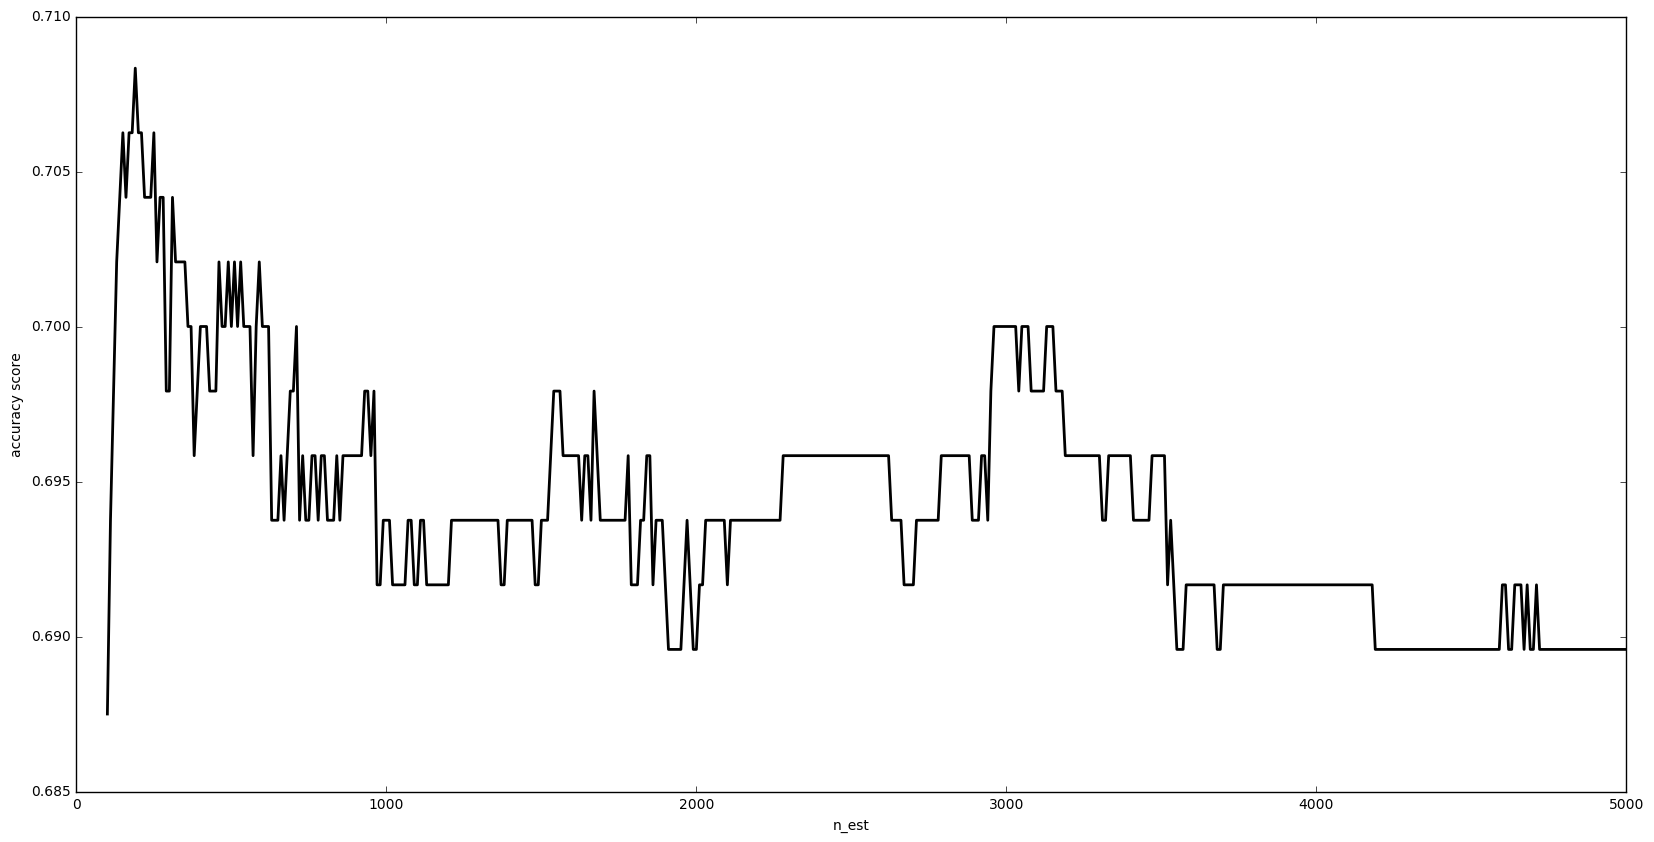

In [530]:
fig, ax = plt.subplots(figsize=(20, 10))
plt.plot([n_est for n_est in range(100, 5001, 10)], accuracy_scores, c='black', linewidth=2)
plt.xlabel('n_est')
plt.ylabel('accuracy score')


Ну вообщем, да, переобучаются (видно снижение доли верных ответов). В теории, в процессе увеличения числа деревьев уменьшается отклонение, но повышается дисперсия. При этом также возрастает гибкость модели, что позволяет ей настроиться на выбросы и
способствует снижению обобщающей способности композиции.

### IV. P. S.
Если вы добрались до этой ячейки, то скорее всего, вы очень устали и хотите... впрочем, каждый в данной ситуации хочет что-то свое :) Так или иначе, здесь вы можете написать фидбек по заданию: указать, с чем возникли проблемы, что оказалось самым сложным, а что - простым, как можно усовершенствовать задание в будущем. Или просто поделитесь мнением о том, какой фактор будет самым важным при сдаче экзамена по курсу.

(・・ ) ?